In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : features,
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLo

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 12:14 - loss: 2.4476 - STD: 0.0878 - MAE: 0.2207

  3/395 [..............................] - ETA: 10s - loss: 2.2503 - STD: 0.0511 - MAE: 0.2199  

  5/395 [..............................] - ETA: 9s - loss: 2.1790 - STD: 0.0498 - MAE: 0.2183 

  7/395 [..............................] - ETA: 9s - loss: 2.1560 - STD: 0.0576 - MAE: 0.2170

  9/395 [..............................] - ETA: 9s - loss: 2.1433 - STD: 0.0602 - MAE: 0.2165

 11/395 [..............................] - ETA: 9s - loss: 2.1324 - STD: 0.0587 - MAE: 0.2164

 13/395 [..............................] - ETA: 9s - loss: 2.1210 - STD: 0.0556 - MAE: 0.2164

 15/395 [>.............................] - ETA: 9s - loss: 2.1123 - STD: 0.0524 - MAE: 0.2165

 18/395 [>.............................] - ETA: 9s - loss: 2.1040 - STD: 0.0486 - MAE: 0.2166

 20/395 [>.............................] - ETA: 9s - loss: 2.0997 - STD: 0.0465 - MAE: 0.2166

 22/395 [>.............................] - ETA: 9s - loss: 2.0958 - STD: 0.0445 - MAE: 0.2167

 24/395 [>.............................] - ETA: 9s - loss: 2.0922 - STD: 0.0429 - MAE: 0.2167

 26/395 [>.............................] - ETA: 9s - loss: 2.0890 - STD: 0.0419 - MAE: 0.2167

 28/395 [=>............................] - ETA: 9s - loss: 2.0864 - STD: 0.0414 - MAE: 0.2167

 30/395 [=>............................] - ETA: 9s - loss: 2.0841 - STD: 0.0413 - MAE: 0.2167

 32/395 [=>............................] - ETA: 9s - loss: 2.0821 - STD: 0.0413 - MAE: 0.2167

 34/395 [=>............................] - ETA: 9s - loss: 2.0801 - STD: 0.0412 - MAE: 0.2166

 37/395 [=>............................] - ETA: 9s - loss: 2.0777 - STD: 0.0408 - MAE: 0.2166

 40/395 [==>...........................] - ETA: 9s - loss: 2.0753 - STD: 0.0400 - MAE: 0.2166

 42/395 [==>...........................] - ETA: 9s - loss: 2.0739 - STD: 0.0395 - MAE: 0.2166

 44/395 [==>...........................] - ETA: 9s - loss: 2.0725 - STD: 0.0391 - MAE: 0.2166

 46/395 [==>...........................] - ETA: 8s - loss: 2.0711 - STD: 0.0388 - MAE: 0.2166

 48/395 [==>...........................] - ETA: 8s - loss: 2.0698 - STD: 0.0386 - MAE: 0.2166

 50/395 [==>...........................] - ETA: 8s - loss: 2.0685 - STD: 0.0384 - MAE: 0.2166

 52/395 [==>...........................] - ETA: 8s - loss: 2.0671 - STD: 0.0382 - MAE: 0.2165

 54/395 [===>..........................] - ETA: 8s - loss: 2.0657 - STD: 0.0380 - MAE: 0.2165

 57/395 [===>..........................] - ETA: 8s - loss: 2.0632 - STD: 0.0378 - MAE: 0.2165

 60/395 [===>..........................] - ETA: 8s - loss: 2.0602 - STD: 0.0376 - MAE: 0.2164

 62/395 [===>..........................] - ETA: 8s - loss: 2.0578 - STD: 0.0376 - MAE: 0.2163

 64/395 [===>..........................] - ETA: 8s - loss: 2.0552 - STD: 0.0377 - MAE: 0.2162

 66/395 [====>.........................] - ETA: 8s - loss: 2.0521 - STD: 0.0377 - MAE: 0.2161

 68/395 [====>.........................] - ETA: 8s - loss: 2.0488 - STD: 0.0380 - MAE: 0.2160

 70/395 [====>.........................] - ETA: 8s - loss: 2.0451 - STD: 0.0384 - MAE: 0.2158

 72/395 [====>.........................] - ETA: 8s - loss: 2.0412 - STD: 0.0389 - MAE: 0.2157

 74/395 [====>.........................] - ETA: 8s - loss: 2.0369 - STD: 0.0394 - MAE: 0.2155

 77/395 [====>.........................] - ETA: 8s - loss: 2.0299 - STD: 0.0404 - MAE: 0.2152

 79/395 [=====>........................] - ETA: 8s - loss: 2.0249 - STD: 0.0411 - MAE: 0.2149

 81/395 [=====>........................] - ETA: 8s - loss: 2.0199 - STD: 0.0419 - MAE: 0.2147

 82/395 [=====>........................] - ETA: 11s - loss: 2.0187 - STD: 0.0422 - MAE: 0.2146

 84/395 [=====>........................] - ETA: 11s - loss: 2.0131 - STD: 0.0430 - MAE: 0.2143

 87/395 [=====>........................] - ETA: 11s - loss: 2.0038 - STD: 0.0442 - MAE: 0.2139

 89/395 [=====>........................] - ETA: 11s - loss: 1.9972 - STD: 0.0451 - MAE: 0.2136

 92/395 [=====>........................] - ETA: 10s - loss: 1.9869 - STD: 0.0465 - MAE: 0.2130

 94/395 [======>.......................] - ETA: 10s - loss: 1.9798 - STD: 0.0475 - MAE: 0.2127

 96/395 [======>.......................] - ETA: 10s - loss: 1.9723 - STD: 0.0486 - MAE: 0.2123

 98/395 [======>.......................] - ETA: 10s - loss: 1.9646 - STD: 0.0497 - MAE: 0.2119

100/395 [======>.......................] - ETA: 10s - loss: 1.9568 - STD: 0.0509 - MAE: 0.2114

102/395 [======>.......................] - ETA: 10s - loss: 1.9488 - STD: 0.0521 - MAE: 0.2110

104/395 [======>.......................] - ETA: 10s - loss: 1.9411 - STD: 0.0533 - MAE: 0.2105

106/395 [=======>......................] - ETA: 9s - loss: 1.9332 - STD: 0.0546 - MAE: 0.2101 

109/395 [=======>......................] - ETA: 9s - loss: 1.9217 - STD: 0.0565 - MAE: 0.2094

111/395 [=======>......................] - ETA: 9s - loss: 1.9142 - STD: 0.0578 - MAE: 0.2089

113/395 [=======>......................] - ETA: 9s - loss: 1.9068 - STD: 0.0590 - MAE: 0.2084

115/395 [=======>......................] - ETA: 9s - loss: 1.8994 - STD: 0.0602 - MAE: 0.2080

117/395 [=======>......................] - ETA: 9s - loss: 1.8921 - STD: 0.0614 - MAE: 0.2075

119/395 [========>.....................] - ETA: 9s - loss: 1.8852 - STD: 0.0626 - MAE: 0.2071

121/395 [========>.....................] - ETA: 9s - loss: 1.8783 - STD: 0.0637 - MAE: 0.2067

123/395 [========>.....................] - ETA: 9s - loss: 1.8714 - STD: 0.0649 - MAE: 0.2062

125/395 [========>.....................] - ETA: 8s - loss: 1.8648 - STD: 0.0660 - MAE: 0.2058

127/395 [========>.....................] - ETA: 8s - loss: 1.8581 - STD: 0.0671 - MAE: 0.2054

129/395 [========>.....................] - ETA: 8s - loss: 1.8517 - STD: 0.0681 - MAE: 0.2050

131/395 [========>.....................] - ETA: 8s - loss: 1.8456 - STD: 0.0692 - MAE: 0.2046

134/395 [=========>....................] - ETA: 8s - loss: 1.8364 - STD: 0.0707 - MAE: 0.2040

136/395 [=========>....................] - ETA: 8s - loss: 1.8305 - STD: 0.0717 - MAE: 0.2036

138/395 [=========>....................] - ETA: 8s - loss: 1.8246 - STD: 0.0727 - MAE: 0.2032

140/395 [=========>....................] - ETA: 8s - loss: 1.8187 - STD: 0.0737 - MAE: 0.2028

142/395 [=========>....................] - ETA: 8s - loss: 1.8131 - STD: 0.0746 - MAE: 0.2024

145/395 [==========>...................] - ETA: 8s - loss: 1.8047 - STD: 0.0760 - MAE: 0.2019

147/395 [==========>...................] - ETA: 7s - loss: 1.7993 - STD: 0.0769 - MAE: 0.2015

149/395 [==========>...................] - ETA: 7s - loss: 1.7939 - STD: 0.0778 - MAE: 0.2012

151/395 [==========>...................] - ETA: 7s - loss: 1.7886 - STD: 0.0787 - MAE: 0.2008

153/395 [==========>...................] - ETA: 7s - loss: 1.7833 - STD: 0.0795 - MAE: 0.2004

155/395 [==========>...................] - ETA: 7s - loss: 1.7781 - STD: 0.0804 - MAE: 0.2001

157/395 [==========>...................] - ETA: 7s - loss: 1.7731 - STD: 0.0812 - MAE: 0.1998

159/395 [===========>..................] - ETA: 7s - loss: 1.7680 - STD: 0.0820 - MAE: 0.1994

162/395 [===========>..................] - ETA: 7s - loss: 1.7606 - STD: 0.0832 - MAE: 0.1989

165/395 [===========>..................] - ETA: 7s - loss: 1.7533 - STD: 0.0844 - MAE: 0.1984

168/395 [===========>..................] - ETA: 7s - loss: 1.7466 - STD: 0.0856 - MAE: 0.1979

171/395 [===========>..................] - ETA: 6s - loss: 1.7401 - STD: 0.0867 - MAE: 0.1974

173/395 [============>.................] - ETA: 6s - loss: 1.7358 - STD: 0.0874 - MAE: 0.1971

175/395 [============>.................] - ETA: 6s - loss: 1.7315 - STD: 0.0882 - MAE: 0.1968

177/395 [============>.................] - ETA: 6s - loss: 1.7273 - STD: 0.0889 - MAE: 0.1965

179/395 [============>.................] - ETA: 6s - loss: 1.7230 - STD: 0.0896 - MAE: 0.1962

181/395 [============>.................] - ETA: 6s - loss: 1.7188 - STD: 0.0903 - MAE: 0.1959

183/395 [============>.................] - ETA: 6s - loss: 1.7145 - STD: 0.0910 - MAE: 0.1956

185/395 [=============>................] - ETA: 6s - loss: 1.7104 - STD: 0.0917 - MAE: 0.1952

187/395 [=============>................] - ETA: 6s - loss: 1.7063 - STD: 0.0924 - MAE: 0.1949

189/395 [=============>................] - ETA: 6s - loss: 1.7023 - STD: 0.0931 - MAE: 0.1946

191/395 [=============>................] - ETA: 6s - loss: 1.6983 - STD: 0.0938 - MAE: 0.1943

193/395 [=============>................] - ETA: 6s - loss: 1.6944 - STD: 0.0944 - MAE: 0.1940

195/395 [=============>................] - ETA: 6s - loss: 1.6904 - STD: 0.0951 - MAE: 0.1937

197/395 [=============>................] - ETA: 6s - loss: 1.6865 - STD: 0.0957 - MAE: 0.1935

199/395 [==============>...............] - ETA: 5s - loss: 1.6827 - STD: 0.0964 - MAE: 0.1932

201/395 [==============>...............] - ETA: 5s - loss: 1.6789 - STD: 0.0970 - MAE: 0.1929

203/395 [==============>...............] - ETA: 5s - loss: 1.6752 - STD: 0.0976 - MAE: 0.1926

205/395 [==============>...............] - ETA: 5s - loss: 1.6716 - STD: 0.0982 - MAE: 0.1923

207/395 [==============>...............] - ETA: 5s - loss: 1.6680 - STD: 0.0988 - MAE: 0.1920

209/395 [==============>...............] - ETA: 5s - loss: 1.6644 - STD: 0.0994 - MAE: 0.1918

211/395 [===============>..............] - ETA: 5s - loss: 1.6609 - STD: 0.1000 - MAE: 0.1915

213/395 [===============>..............] - ETA: 5s - loss: 1.6574 - STD: 0.1006 - MAE: 0.1912

215/395 [===============>..............] - ETA: 5s - loss: 1.6538 - STD: 0.1012 - MAE: 0.1910

217/395 [===============>..............] - ETA: 5s - loss: 1.6504 - STD: 0.1018 - MAE: 0.1907

220/395 [===============>..............] - ETA: 5s - loss: 1.6453 - STD: 0.1026 - MAE: 0.1903

222/395 [===============>..............] - ETA: 5s - loss: 1.6420 - STD: 0.1032 - MAE: 0.1900

224/395 [================>.............] - ETA: 5s - loss: 1.6386 - STD: 0.1038 - MAE: 0.1898

226/395 [================>.............] - ETA: 5s - loss: 1.6355 - STD: 0.1043 - MAE: 0.1895

228/395 [================>.............] - ETA: 4s - loss: 1.6323 - STD: 0.1049 - MAE: 0.1893

230/395 [================>.............] - ETA: 4s - loss: 1.6292 - STD: 0.1054 - MAE: 0.1890

232/395 [================>.............] - ETA: 4s - loss: 1.6260 - STD: 0.1059 - MAE: 0.1887

234/395 [================>.............] - ETA: 4s - loss: 1.6228 - STD: 0.1065 - MAE: 0.1885

236/395 [================>.............] - ETA: 4s - loss: 1.6197 - STD: 0.1070 - MAE: 0.1882

238/395 [=================>............] - ETA: 4s - loss: 1.6167 - STD: 0.1075 - MAE: 0.1880

240/395 [=================>............] - ETA: 4s - loss: 1.6136 - STD: 0.1080 - MAE: 0.1877

242/395 [=================>............] - ETA: 4s - loss: 1.6106 - STD: 0.1086 - MAE: 0.1875

244/395 [=================>............] - ETA: 4s - loss: 1.6076 - STD: 0.1091 - MAE: 0.1873

246/395 [=================>............] - ETA: 4s - loss: 1.6047 - STD: 0.1096 - MAE: 0.1870

248/395 [=================>............] - ETA: 4s - loss: 1.6017 - STD: 0.1101 - MAE: 0.1868

250/395 [=================>............] - ETA: 4s - loss: 1.5988 - STD: 0.1106 - MAE: 0.1865

252/395 [==================>...........] - ETA: 4s - loss: 1.5961 - STD: 0.1111 - MAE: 0.1863

254/395 [==================>...........] - ETA: 4s - loss: 1.5937 - STD: 0.1116 - MAE: 0.1861

256/395 [==================>...........] - ETA: 4s - loss: 1.5910 - STD: 0.1121 - MAE: 0.1859

258/395 [==================>...........] - ETA: 4s - loss: 1.5884 - STD: 0.1125 - MAE: 0.1856

260/395 [==================>...........] - ETA: 3s - loss: 1.5858 - STD: 0.1130 - MAE: 0.1854

262/395 [==================>...........] - ETA: 3s - loss: 1.5831 - STD: 0.1135 - MAE: 0.1852

264/395 [===================>..........] - ETA: 3s - loss: 1.5804 - STD: 0.1140 - MAE: 0.1850

266/395 [===================>..........] - ETA: 3s - loss: 1.5778 - STD: 0.1144 - MAE: 0.1847

268/395 [===================>..........] - ETA: 3s - loss: 1.5752 - STD: 0.1149 - MAE: 0.1845

270/395 [===================>..........] - ETA: 3s - loss: 1.5726 - STD: 0.1153 - MAE: 0.1843

272/395 [===================>..........] - ETA: 3s - loss: 1.5700 - STD: 0.1157 - MAE: 0.1841

274/395 [===================>..........] - ETA: 3s - loss: 1.5674 - STD: 0.1162 - MAE: 0.1839

276/395 [===================>..........] - ETA: 3s - loss: 1.5650 - STD: 0.1166 - MAE: 0.1837

278/395 [====================>.........] - ETA: 3s - loss: 1.5624 - STD: 0.1170 - MAE: 0.1835

280/395 [====================>.........] - ETA: 3s - loss: 1.5599 - STD: 0.1174 - MAE: 0.1832

283/395 [====================>.........] - ETA: 3s - loss: 1.5563 - STD: 0.1181 - MAE: 0.1829

285/395 [====================>.........] - ETA: 3s - loss: 1.5539 - STD: 0.1185 - MAE: 0.1827

287/395 [====================>.........] - ETA: 3s - loss: 1.5515 - STD: 0.1189 - MAE: 0.1825

289/395 [====================>.........] - ETA: 3s - loss: 1.5491 - STD: 0.1193 - MAE: 0.1823

291/395 [=====================>........] - ETA: 3s - loss: 1.5468 - STD: 0.1197 - MAE: 0.1821

293/395 [=====================>........] - ETA: 2s - loss: 1.5445 - STD: 0.1201 - MAE: 0.1819

295/395 [=====================>........] - ETA: 2s - loss: 1.5421 - STD: 0.1205 - MAE: 0.1817

298/395 [=====================>........] - ETA: 2s - loss: 1.5387 - STD: 0.1211 - MAE: 0.1814

300/395 [=====================>........] - ETA: 2s - loss: 1.5364 - STD: 0.1215 - MAE: 0.1813

302/395 [=====================>........] - ETA: 2s - loss: 1.5342 - STD: 0.1219 - MAE: 0.1811

304/395 [======================>.......] - ETA: 2s - loss: 1.5320 - STD: 0.1223 - MAE: 0.1809

306/395 [======================>.......] - ETA: 2s - loss: 1.5298 - STD: 0.1226 - MAE: 0.1807

308/395 [======================>.......] - ETA: 2s - loss: 1.5277 - STD: 0.1230 - MAE: 0.1805

310/395 [======================>.......] - ETA: 2s - loss: 1.5255 - STD: 0.1234 - MAE: 0.1803

312/395 [======================>.......] - ETA: 2s - loss: 1.5233 - STD: 0.1237 - MAE: 0.1801

314/395 [======================>.......] - ETA: 2s - loss: 1.5211 - STD: 0.1241 - MAE: 0.1799

317/395 [=======================>......] - ETA: 2s - loss: 1.5188 - STD: 0.1247 - MAE: 0.1797

319/395 [=======================>......] - ETA: 2s - loss: 1.5170 - STD: 0.1250 - MAE: 0.1795

321/395 [=======================>......] - ETA: 2s - loss: 1.5152 - STD: 0.1254 - MAE: 0.1794

323/395 [=======================>......] - ETA: 2s - loss: 1.5133 - STD: 0.1257 - MAE: 0.1792

325/395 [=======================>......] - ETA: 2s - loss: 1.5113 - STD: 0.1261 - MAE: 0.1790

327/395 [=======================>......] - ETA: 1s - loss: 1.5094 - STD: 0.1264 - MAE: 0.1789

329/395 [=======================>......] - ETA: 1s - loss: 1.5074 - STD: 0.1267 - MAE: 0.1787

331/395 [========================>.....] - ETA: 1s - loss: 1.5055 - STD: 0.1271 - MAE: 0.1785

333/395 [========================>.....] - ETA: 1s - loss: 1.5035 - STD: 0.1274 - MAE: 0.1784

336/395 [========================>.....] - ETA: 1s - loss: 1.5007 - STD: 0.1279 - MAE: 0.1781

338/395 [========================>.....] - ETA: 1s - loss: 1.4988 - STD: 0.1282 - MAE: 0.1780

341/395 [========================>.....] - ETA: 1s - loss: 1.4959 - STD: 0.1287 - MAE: 0.1777

343/395 [=========================>....] - ETA: 1s - loss: 1.4940 - STD: 0.1290 - MAE: 0.1775

345/395 [=========================>....] - ETA: 1s - loss: 1.4921 - STD: 0.1293 - MAE: 0.1774

347/395 [=========================>....] - ETA: 1s - loss: 1.4903 - STD: 0.1296 - MAE: 0.1772

349/395 [=========================>....] - ETA: 1s - loss: 1.4886 - STD: 0.1299 - MAE: 0.1771

351/395 [=========================>....] - ETA: 1s - loss: 1.4867 - STD: 0.1302 - MAE: 0.1769

353/395 [=========================>....] - ETA: 1s - loss: 1.4850 - STD: 0.1305 - MAE: 0.1768

355/395 [=========================>....] - ETA: 1s - loss: 1.4833 - STD: 0.1308 - MAE: 0.1766

357/395 [==========================>...] - ETA: 1s - loss: 1.4814 - STD: 0.1311 - MAE: 0.1764

359/395 [==========================>...] - ETA: 1s - loss: 1.4797 - STD: 0.1314 - MAE: 0.1763

361/395 [==========================>...] - ETA: 0s - loss: 1.4780 - STD: 0.1317 - MAE: 0.1761

363/395 [==========================>...] - ETA: 0s - loss: 1.4762 - STD: 0.1320 - MAE: 0.1760

365/395 [==========================>...] - ETA: 0s - loss: 1.4747 - STD: 0.1323 - MAE: 0.1759

367/395 [==========================>...] - ETA: 0s - loss: 1.4731 - STD: 0.1326 - MAE: 0.1757

369/395 [===========================>..] - ETA: 0s - loss: 1.4716 - STD: 0.1329 - MAE: 0.1756

371/395 [===========================>..] - ETA: 0s - loss: 1.4701 - STD: 0.1332 - MAE: 0.1754

373/395 [===========================>..] - ETA: 0s - loss: 1.4685 - STD: 0.1334 - MAE: 0.1753

375/395 [===========================>..] - ETA: 0s - loss: 1.4670 - STD: 0.1337 - MAE: 0.1751

377/395 [===========================>..] - ETA: 0s - loss: 1.4654 - STD: 0.1340 - MAE: 0.1750

379/395 [===========================>..] - ETA: 0s - loss: 1.4638 - STD: 0.1343 - MAE: 0.1749

381/395 [===========================>..] - ETA: 0s - loss: 1.4622 - STD: 0.1345 - MAE: 0.1747

383/395 [============================>.] - ETA: 0s - loss: 1.4606 - STD: 0.1348 - MAE: 0.1746

385/395 [============================>.] - ETA: 0s - loss: 1.4590 - STD: 0.1350 - MAE: 0.1745

387/395 [============================>.] - ETA: 0s - loss: 1.4575 - STD: 0.1353 - MAE: 0.1743

389/395 [============================>.] - ETA: 0s - loss: 1.4559 - STD: 0.1355 - MAE: 0.1742

391/395 [============================>.] - ETA: 0s - loss: 1.4543 - STD: 0.1358 - MAE: 0.1740

393/395 [============================>.] - ETA: 0s - loss: 1.4528 - STD: 0.1361 - MAE: 0.1739

395/395 [==============================] - 15s 32ms/step - loss: 1.4512 - STD: 0.1363 - MAE: 0.1738 - val_loss: 1.1865 - val_STD: 0.1878 - val_MAE: 0.1464


Epoch 2/10000


  1/395 [..............................] - ETA: 22s - loss: 1.1623 - STD: 0.1876 - MAE: 0.1474

  4/395 [..............................] - ETA: 9s - loss: 1.1534 - STD: 0.1872 - MAE: 0.1473 

  7/395 [..............................] - ETA: 9s - loss: 1.1497 - STD: 0.1877 - MAE: 0.1469

  9/395 [..............................] - ETA: 9s - loss: 1.1515 - STD: 0.1873 - MAE: 0.1471

 11/395 [..............................] - ETA: 9s - loss: 1.1484 - STD: 0.1872 - MAE: 0.1469

 13/395 [..............................] - ETA: 9s - loss: 1.1477 - STD: 0.1874 - MAE: 0.1468

 15/395 [>.............................] - ETA: 9s - loss: 1.1476 - STD: 0.1876 - MAE: 0.1467

 17/395 [>.............................] - ETA: 9s - loss: 1.1500 - STD: 0.1878 - MAE: 0.1468

 19/395 [>.............................] - ETA: 9s - loss: 1.1515 - STD: 0.1879 - MAE: 0.1468

 21/395 [>.............................] - ETA: 9s - loss: 1.1517 - STD: 0.1880 - MAE: 0.1468

 23/395 [>.............................] - ETA: 9s - loss: 1.1515 - STD: 0.1881 - MAE: 0.1468

 25/395 [>.............................] - ETA: 9s - loss: 1.1504 - STD: 0.1881 - MAE: 0.1467

 27/395 [=>............................] - ETA: 9s - loss: 1.1497 - STD: 0.1881 - MAE: 0.1467

 29/395 [=>............................] - ETA: 9s - loss: 1.1493 - STD: 0.1881 - MAE: 0.1466

 31/395 [=>............................] - ETA: 9s - loss: 1.1499 - STD: 0.1882 - MAE: 0.1466

 33/395 [=>............................] - ETA: 9s - loss: 1.1492 - STD: 0.1883 - MAE: 0.1466

 35/395 [=>............................] - ETA: 9s - loss: 1.1491 - STD: 0.1883 - MAE: 0.1466

 37/395 [=>............................] - ETA: 9s - loss: 1.1504 - STD: 0.1883 - MAE: 0.1466

 39/395 [=>............................] - ETA: 9s - loss: 1.1490 - STD: 0.1884 - MAE: 0.1465

 41/395 [==>...........................] - ETA: 9s - loss: 1.1482 - STD: 0.1884 - MAE: 0.1465

 43/395 [==>...........................] - ETA: 9s - loss: 1.1471 - STD: 0.1885 - MAE: 0.1464

 45/395 [==>...........................] - ETA: 9s - loss: 1.1474 - STD: 0.1886 - MAE: 0.1464

 47/395 [==>...........................] - ETA: 8s - loss: 1.1474 - STD: 0.1886 - MAE: 0.1464

 49/395 [==>...........................] - ETA: 8s - loss: 1.1469 - STD: 0.1887 - MAE: 0.1463

 51/395 [==>...........................] - ETA: 8s - loss: 1.1477 - STD: 0.1887 - MAE: 0.1464

 53/395 [===>..........................] - ETA: 8s - loss: 1.1473 - STD: 0.1887 - MAE: 0.1463

 55/395 [===>..........................] - ETA: 8s - loss: 1.1482 - STD: 0.1888 - MAE: 0.1463

 57/395 [===>..........................] - ETA: 8s - loss: 1.1478 - STD: 0.1889 - MAE: 0.1463

 59/395 [===>..........................] - ETA: 8s - loss: 1.1476 - STD: 0.1889 - MAE: 0.1462

 61/395 [===>..........................] - ETA: 8s - loss: 1.1478 - STD: 0.1890 - MAE: 0.1462

 63/395 [===>..........................] - ETA: 8s - loss: 1.1478 - STD: 0.1891 - MAE: 0.1462

 65/395 [===>..........................] - ETA: 8s - loss: 1.1476 - STD: 0.1892 - MAE: 0.1461

 67/395 [====>.........................] - ETA: 8s - loss: 1.1474 - STD: 0.1892 - MAE: 0.1461

 69/395 [====>.........................] - ETA: 8s - loss: 1.1467 - STD: 0.1892 - MAE: 0.1461

 71/395 [====>.........................] - ETA: 8s - loss: 1.1461 - STD: 0.1892 - MAE: 0.1460

 73/395 [====>.........................] - ETA: 8s - loss: 1.1458 - STD: 0.1893 - MAE: 0.1460

 75/395 [====>.........................] - ETA: 8s - loss: 1.1455 - STD: 0.1892 - MAE: 0.1460

 77/395 [====>.........................] - ETA: 8s - loss: 1.1450 - STD: 0.1893 - MAE: 0.1460

 79/395 [=====>........................] - ETA: 8s - loss: 1.1444 - STD: 0.1893 - MAE: 0.1460

 81/395 [=====>........................] - ETA: 8s - loss: 1.1440 - STD: 0.1893 - MAE: 0.1459

 83/395 [=====>........................] - ETA: 8s - loss: 1.1433 - STD: 0.1894 - MAE: 0.1459

 85/395 [=====>........................] - ETA: 7s - loss: 1.1430 - STD: 0.1894 - MAE: 0.1458

 87/395 [=====>........................] - ETA: 7s - loss: 1.1424 - STD: 0.1895 - MAE: 0.1458

 89/395 [=====>........................] - ETA: 7s - loss: 1.1419 - STD: 0.1896 - MAE: 0.1457

 91/395 [=====>........................] - ETA: 7s - loss: 1.1414 - STD: 0.1896 - MAE: 0.1457

 93/395 [======>.......................] - ETA: 7s - loss: 1.1408 - STD: 0.1896 - MAE: 0.1456

 95/395 [======>.......................] - ETA: 7s - loss: 1.1402 - STD: 0.1897 - MAE: 0.1456

 97/395 [======>.......................] - ETA: 7s - loss: 1.1398 - STD: 0.1897 - MAE: 0.1456

 99/395 [======>.......................] - ETA: 7s - loss: 1.1394 - STD: 0.1898 - MAE: 0.1455

101/395 [======>.......................] - ETA: 7s - loss: 1.1390 - STD: 0.1898 - MAE: 0.1455

103/395 [======>.......................] - ETA: 7s - loss: 1.1382 - STD: 0.1899 - MAE: 0.1454

105/395 [======>.......................] - ETA: 7s - loss: 1.1377 - STD: 0.1899 - MAE: 0.1454

107/395 [=======>......................] - ETA: 7s - loss: 1.1374 - STD: 0.1900 - MAE: 0.1453

109/395 [=======>......................] - ETA: 7s - loss: 1.1373 - STD: 0.1901 - MAE: 0.1453

111/395 [=======>......................] - ETA: 7s - loss: 1.1370 - STD: 0.1901 - MAE: 0.1453

113/395 [=======>......................] - ETA: 7s - loss: 1.1364 - STD: 0.1902 - MAE: 0.1452

115/395 [=======>......................] - ETA: 7s - loss: 1.1362 - STD: 0.1902 - MAE: 0.1452

117/395 [=======>......................] - ETA: 7s - loss: 1.1362 - STD: 0.1903 - MAE: 0.1452

119/395 [========>.....................] - ETA: 7s - loss: 1.1357 - STD: 0.1904 - MAE: 0.1451

121/395 [========>.....................] - ETA: 7s - loss: 1.1353 - STD: 0.1904 - MAE: 0.1451

123/395 [========>.....................] - ETA: 7s - loss: 1.1352 - STD: 0.1905 - MAE: 0.1450

125/395 [========>.....................] - ETA: 6s - loss: 1.1347 - STD: 0.1905 - MAE: 0.1450

127/395 [========>.....................] - ETA: 6s - loss: 1.1350 - STD: 0.1906 - MAE: 0.1450

129/395 [========>.....................] - ETA: 6s - loss: 1.1348 - STD: 0.1906 - MAE: 0.1450

131/395 [========>.....................] - ETA: 6s - loss: 1.1351 - STD: 0.1907 - MAE: 0.1450

133/395 [=========>....................] - ETA: 6s - loss: 1.1347 - STD: 0.1907 - MAE: 0.1449

135/395 [=========>....................] - ETA: 6s - loss: 1.1346 - STD: 0.1907 - MAE: 0.1449

137/395 [=========>....................] - ETA: 6s - loss: 1.1345 - STD: 0.1908 - MAE: 0.1449

139/395 [=========>....................] - ETA: 6s - loss: 1.1342 - STD: 0.1908 - MAE: 0.1449

141/395 [=========>....................] - ETA: 6s - loss: 1.1338 - STD: 0.1909 - MAE: 0.1448

144/395 [=========>....................] - ETA: 6s - loss: 1.1333 - STD: 0.1909 - MAE: 0.1448

146/395 [==========>...................] - ETA: 6s - loss: 1.1329 - STD: 0.1909 - MAE: 0.1448

149/395 [==========>...................] - ETA: 6s - loss: 1.1323 - STD: 0.1910 - MAE: 0.1447

151/395 [==========>...................] - ETA: 6s - loss: 1.1323 - STD: 0.1910 - MAE: 0.1447

153/395 [==========>...................] - ETA: 6s - loss: 1.1320 - STD: 0.1910 - MAE: 0.1447

155/395 [==========>...................] - ETA: 6s - loss: 1.1316 - STD: 0.1911 - MAE: 0.1446

157/395 [==========>...................] - ETA: 6s - loss: 1.1311 - STD: 0.1911 - MAE: 0.1446

159/395 [===========>..................] - ETA: 6s - loss: 1.1307 - STD: 0.1911 - MAE: 0.1446

161/395 [===========>..................] - ETA: 6s - loss: 1.1304 - STD: 0.1912 - MAE: 0.1445

163/395 [===========>..................] - ETA: 5s - loss: 1.1299 - STD: 0.1912 - MAE: 0.1445

165/395 [===========>..................] - ETA: 5s - loss: 1.1294 - STD: 0.1912 - MAE: 0.1445

167/395 [===========>..................] - ETA: 5s - loss: 1.1290 - STD: 0.1913 - MAE: 0.1444

169/395 [===========>..................] - ETA: 5s - loss: 1.1285 - STD: 0.1913 - MAE: 0.1444

171/395 [===========>..................] - ETA: 5s - loss: 1.1281 - STD: 0.1914 - MAE: 0.1443

173/395 [============>.................] - ETA: 5s - loss: 1.1278 - STD: 0.1914 - MAE: 0.1443

175/395 [============>.................] - ETA: 5s - loss: 1.1274 - STD: 0.1915 - MAE: 0.1443

177/395 [============>.................] - ETA: 5s - loss: 1.1271 - STD: 0.1915 - MAE: 0.1442

179/395 [============>.................] - ETA: 5s - loss: 1.1268 - STD: 0.1916 - MAE: 0.1442

181/395 [============>.................] - ETA: 5s - loss: 1.1265 - STD: 0.1916 - MAE: 0.1442

183/395 [============>.................] - ETA: 5s - loss: 1.1263 - STD: 0.1917 - MAE: 0.1441

185/395 [=============>................] - ETA: 5s - loss: 1.1259 - STD: 0.1917 - MAE: 0.1441

187/395 [=============>................] - ETA: 5s - loss: 1.1257 - STD: 0.1918 - MAE: 0.1441

189/395 [=============>................] - ETA: 5s - loss: 1.1254 - STD: 0.1918 - MAE: 0.1440

192/395 [=============>................] - ETA: 5s - loss: 1.1248 - STD: 0.1919 - MAE: 0.1440

194/395 [=============>................] - ETA: 5s - loss: 1.1246 - STD: 0.1919 - MAE: 0.1440

196/395 [=============>................] - ETA: 5s - loss: 1.1243 - STD: 0.1920 - MAE: 0.1439

198/395 [==============>...............] - ETA: 5s - loss: 1.1239 - STD: 0.1920 - MAE: 0.1439

200/395 [==============>...............] - ETA: 5s - loss: 1.1235 - STD: 0.1921 - MAE: 0.1439

202/395 [==============>...............] - ETA: 4s - loss: 1.1233 - STD: 0.1921 - MAE: 0.1438

204/395 [==============>...............] - ETA: 4s - loss: 1.1230 - STD: 0.1921 - MAE: 0.1438

206/395 [==============>...............] - ETA: 4s - loss: 1.1227 - STD: 0.1922 - MAE: 0.1438

208/395 [==============>...............] - ETA: 4s - loss: 1.1223 - STD: 0.1922 - MAE: 0.1437

210/395 [==============>...............] - ETA: 4s - loss: 1.1219 - STD: 0.1922 - MAE: 0.1437

212/395 [===============>..............] - ETA: 4s - loss: 1.1216 - STD: 0.1923 - MAE: 0.1437

214/395 [===============>..............] - ETA: 4s - loss: 1.1212 - STD: 0.1923 - MAE: 0.1436

216/395 [===============>..............] - ETA: 4s - loss: 1.1208 - STD: 0.1924 - MAE: 0.1436

218/395 [===============>..............] - ETA: 4s - loss: 1.1207 - STD: 0.1924 - MAE: 0.1436

220/395 [===============>..............] - ETA: 4s - loss: 1.1205 - STD: 0.1924 - MAE: 0.1436

223/395 [===============>..............] - ETA: 4s - loss: 1.1202 - STD: 0.1925 - MAE: 0.1435

225/395 [================>.............] - ETA: 4s - loss: 1.1198 - STD: 0.1925 - MAE: 0.1435

227/395 [================>.............] - ETA: 4s - loss: 1.1197 - STD: 0.1926 - MAE: 0.1435

229/395 [================>.............] - ETA: 4s - loss: 1.1194 - STD: 0.1926 - MAE: 0.1434

231/395 [================>.............] - ETA: 4s - loss: 1.1191 - STD: 0.1927 - MAE: 0.1434

233/395 [================>.............] - ETA: 4s - loss: 1.1189 - STD: 0.1927 - MAE: 0.1434

235/395 [================>.............] - ETA: 4s - loss: 1.1185 - STD: 0.1927 - MAE: 0.1433

237/395 [=================>............] - ETA: 4s - loss: 1.1182 - STD: 0.1928 - MAE: 0.1433

239/395 [=================>............] - ETA: 4s - loss: 1.1179 - STD: 0.1928 - MAE: 0.1433

241/395 [=================>............] - ETA: 3s - loss: 1.1175 - STD: 0.1928 - MAE: 0.1433

243/395 [=================>............] - ETA: 3s - loss: 1.1172 - STD: 0.1929 - MAE: 0.1432

245/395 [=================>............] - ETA: 3s - loss: 1.1168 - STD: 0.1929 - MAE: 0.1432

247/395 [=================>............] - ETA: 3s - loss: 1.1164 - STD: 0.1929 - MAE: 0.1432

249/395 [=================>............] - ETA: 3s - loss: 1.1161 - STD: 0.1930 - MAE: 0.1431

251/395 [==================>...........] - ETA: 3s - loss: 1.1157 - STD: 0.1930 - MAE: 0.1431

253/395 [==================>...........] - ETA: 3s - loss: 1.1154 - STD: 0.1930 - MAE: 0.1431

255/395 [==================>...........] - ETA: 3s - loss: 1.1150 - STD: 0.1931 - MAE: 0.1430

257/395 [==================>...........] - ETA: 3s - loss: 1.1146 - STD: 0.1931 - MAE: 0.1430

259/395 [==================>...........] - ETA: 3s - loss: 1.1142 - STD: 0.1931 - MAE: 0.1430

261/395 [==================>...........] - ETA: 3s - loss: 1.1138 - STD: 0.1932 - MAE: 0.1429

263/395 [==================>...........] - ETA: 3s - loss: 1.1135 - STD: 0.1932 - MAE: 0.1429

265/395 [===================>..........] - ETA: 3s - loss: 1.1133 - STD: 0.1933 - MAE: 0.1429

267/395 [===================>..........] - ETA: 3s - loss: 1.1130 - STD: 0.1933 - MAE: 0.1428

269/395 [===================>..........] - ETA: 3s - loss: 1.1127 - STD: 0.1934 - MAE: 0.1428

271/395 [===================>..........] - ETA: 3s - loss: 1.1124 - STD: 0.1934 - MAE: 0.1428

273/395 [===================>..........] - ETA: 3s - loss: 1.1121 - STD: 0.1935 - MAE: 0.1427

276/395 [===================>..........] - ETA: 3s - loss: 1.1116 - STD: 0.1935 - MAE: 0.1427

278/395 [====================>.........] - ETA: 3s - loss: 1.1114 - STD: 0.1935 - MAE: 0.1427

280/395 [====================>.........] - ETA: 2s - loss: 1.1110 - STD: 0.1936 - MAE: 0.1426

282/395 [====================>.........] - ETA: 2s - loss: 1.1107 - STD: 0.1936 - MAE: 0.1426

284/395 [====================>.........] - ETA: 2s - loss: 1.1103 - STD: 0.1937 - MAE: 0.1426

286/395 [====================>.........] - ETA: 2s - loss: 1.1101 - STD: 0.1937 - MAE: 0.1426

288/395 [====================>.........] - ETA: 2s - loss: 1.1099 - STD: 0.1937 - MAE: 0.1425

290/395 [=====================>........] - ETA: 2s - loss: 1.1096 - STD: 0.1938 - MAE: 0.1425

292/395 [=====================>........] - ETA: 2s - loss: 1.1094 - STD: 0.1938 - MAE: 0.1425

294/395 [=====================>........] - ETA: 2s - loss: 1.1091 - STD: 0.1938 - MAE: 0.1425

296/395 [=====================>........] - ETA: 2s - loss: 1.1090 - STD: 0.1939 - MAE: 0.1424

298/395 [=====================>........] - ETA: 2s - loss: 1.1089 - STD: 0.1939 - MAE: 0.1424

301/395 [=====================>........] - ETA: 2s - loss: 1.1086 - STD: 0.1940 - MAE: 0.1424

304/395 [======================>.......] - ETA: 2s - loss: 1.1086 - STD: 0.1940 - MAE: 0.1424

307/395 [======================>.......] - ETA: 2s - loss: 1.1083 - STD: 0.1941 - MAE: 0.1423

309/395 [======================>.......] - ETA: 2s - loss: 1.1080 - STD: 0.1941 - MAE: 0.1423

312/395 [======================>.......] - ETA: 2s - loss: 1.1077 - STD: 0.1941 - MAE: 0.1423

314/395 [======================>.......] - ETA: 2s - loss: 1.1075 - STD: 0.1942 - MAE: 0.1422

316/395 [=======================>......] - ETA: 2s - loss: 1.1071 - STD: 0.1942 - MAE: 0.1422

318/395 [=======================>......] - ETA: 1s - loss: 1.1069 - STD: 0.1942 - MAE: 0.1422

320/395 [=======================>......] - ETA: 1s - loss: 1.1066 - STD: 0.1942 - MAE: 0.1422

322/395 [=======================>......] - ETA: 1s - loss: 1.1064 - STD: 0.1943 - MAE: 0.1421

324/395 [=======================>......] - ETA: 1s - loss: 1.1062 - STD: 0.1943 - MAE: 0.1421

326/395 [=======================>......] - ETA: 1s - loss: 1.1061 - STD: 0.1943 - MAE: 0.1421

328/395 [=======================>......] - ETA: 1s - loss: 1.1059 - STD: 0.1943 - MAE: 0.1421

330/395 [========================>.....] - ETA: 1s - loss: 1.1056 - STD: 0.1944 - MAE: 0.1421

333/395 [========================>.....] - ETA: 1s - loss: 1.1053 - STD: 0.1944 - MAE: 0.1420

335/395 [========================>.....] - ETA: 1s - loss: 1.1049 - STD: 0.1944 - MAE: 0.1420

337/395 [========================>.....] - ETA: 1s - loss: 1.1046 - STD: 0.1945 - MAE: 0.1420

339/395 [========================>.....] - ETA: 1s - loss: 1.1042 - STD: 0.1945 - MAE: 0.1419

342/395 [========================>.....] - ETA: 1s - loss: 1.1039 - STD: 0.1946 - MAE: 0.1419

344/395 [=========================>....] - ETA: 1s - loss: 1.1037 - STD: 0.1946 - MAE: 0.1419

346/395 [=========================>....] - ETA: 1s - loss: 1.1033 - STD: 0.1946 - MAE: 0.1418

348/395 [=========================>....] - ETA: 1s - loss: 1.1030 - STD: 0.1947 - MAE: 0.1418

350/395 [=========================>....] - ETA: 1s - loss: 1.1027 - STD: 0.1947 - MAE: 0.1418

352/395 [=========================>....] - ETA: 1s - loss: 1.1025 - STD: 0.1947 - MAE: 0.1418

354/395 [=========================>....] - ETA: 1s - loss: 1.1022 - STD: 0.1948 - MAE: 0.1417

356/395 [==========================>...] - ETA: 1s - loss: 1.1020 - STD: 0.1948 - MAE: 0.1417

358/395 [==========================>...] - ETA: 0s - loss: 1.1017 - STD: 0.1948 - MAE: 0.1417

360/395 [==========================>...] - ETA: 0s - loss: 1.1014 - STD: 0.1949 - MAE: 0.1417

362/395 [==========================>...] - ETA: 0s - loss: 1.1011 - STD: 0.1949 - MAE: 0.1416

364/395 [==========================>...] - ETA: 0s - loss: 1.1008 - STD: 0.1949 - MAE: 0.1416

366/395 [==========================>...] - ETA: 0s - loss: 1.1005 - STD: 0.1949 - MAE: 0.1416

368/395 [==========================>...] - ETA: 0s - loss: 1.1002 - STD: 0.1950 - MAE: 0.1415

370/395 [===========================>..] - ETA: 0s - loss: 1.0999 - STD: 0.1950 - MAE: 0.1415

372/395 [===========================>..] - ETA: 0s - loss: 1.0996 - STD: 0.1950 - MAE: 0.1415

374/395 [===========================>..] - ETA: 0s - loss: 1.0993 - STD: 0.1951 - MAE: 0.1415

376/395 [===========================>..] - ETA: 0s - loss: 1.0990 - STD: 0.1951 - MAE: 0.1414

378/395 [===========================>..] - ETA: 0s - loss: 1.0987 - STD: 0.1951 - MAE: 0.1414

381/395 [===========================>..] - ETA: 0s - loss: 1.0985 - STD: 0.1952 - MAE: 0.1414

383/395 [============================>.] - ETA: 0s - loss: 1.0984 - STD: 0.1952 - MAE: 0.1413

385/395 [============================>.] - ETA: 0s - loss: 1.0982 - STD: 0.1953 - MAE: 0.1413

388/395 [============================>.] - ETA: 0s - loss: 1.0980 - STD: 0.1953 - MAE: 0.1413

390/395 [============================>.] - ETA: 0s - loss: 1.0977 - STD: 0.1953 - MAE: 0.1413

392/395 [============================>.] - ETA: 0s - loss: 1.0975 - STD: 0.1954 - MAE: 0.1412

394/395 [============================>.] - ETA: 0s - loss: 1.0972 - STD: 0.1954 - MAE: 0.1412

395/395 [==============================] - 11s 28ms/step - loss: 1.0970 - STD: 0.1954 - MAE: 0.1412 - val_loss: 1.0992 - val_STD: 0.2042 - val_MAE: 0.1371


Epoch 3/10000


  1/395 [..............................] - ETA: 22s - loss: 1.0280 - STD: 0.2032 - MAE: 0.1345

  3/395 [..............................] - ETA: 10s - loss: 1.0381 - STD: 0.2023 - MAE: 0.1352

  5/395 [..............................] - ETA: 10s - loss: 1.0415 - STD: 0.2018 - MAE: 0.1357

  7/395 [..............................] - ETA: 10s - loss: 1.0427 - STD: 0.2017 - MAE: 0.1358

  9/395 [..............................] - ETA: 10s - loss: 1.0422 - STD: 0.2015 - MAE: 0.1359

 11/395 [..............................] - ETA: 9s - loss: 1.0414 - STD: 0.2014 - MAE: 0.1359 

 13/395 [..............................] - ETA: 9s - loss: 1.0398 - STD: 0.2016 - MAE: 0.1357

 15/395 [>.............................] - ETA: 9s - loss: 1.0391 - STD: 0.2016 - MAE: 0.1356

 17/395 [>.............................] - ETA: 9s - loss: 1.0380 - STD: 0.2018 - MAE: 0.1355

 20/395 [>.............................] - ETA: 9s - loss: 1.0362 - STD: 0.2019 - MAE: 0.1353

 22/395 [>.............................] - ETA: 9s - loss: 1.0362 - STD: 0.2020 - MAE: 0.1353

 24/395 [>.............................] - ETA: 9s - loss: 1.0373 - STD: 0.2021 - MAE: 0.1354

 26/395 [>.............................] - ETA: 9s - loss: 1.0372 - STD: 0.2021 - MAE: 0.1354

 28/395 [=>............................] - ETA: 9s - loss: 1.0376 - STD: 0.2022 - MAE: 0.1354

 30/395 [=>............................] - ETA: 9s - loss: 1.0371 - STD: 0.2022 - MAE: 0.1353

 32/395 [=>............................] - ETA: 9s - loss: 1.0379 - STD: 0.2022 - MAE: 0.1354

 34/395 [=>............................] - ETA: 9s - loss: 1.0370 - STD: 0.2023 - MAE: 0.1353

 36/395 [=>............................] - ETA: 9s - loss: 1.0364 - STD: 0.2023 - MAE: 0.1352

 38/395 [=>............................] - ETA: 9s - loss: 1.0361 - STD: 0.2024 - MAE: 0.1352

 40/395 [==>...........................] - ETA: 9s - loss: 1.0361 - STD: 0.2024 - MAE: 0.1352

 42/395 [==>...........................] - ETA: 9s - loss: 1.0358 - STD: 0.2025 - MAE: 0.1351

 44/395 [==>...........................] - ETA: 9s - loss: 1.0365 - STD: 0.2025 - MAE: 0.1352

 46/395 [==>...........................] - ETA: 9s - loss: 1.0357 - STD: 0.2026 - MAE: 0.1351

 48/395 [==>...........................] - ETA: 8s - loss: 1.0354 - STD: 0.2026 - MAE: 0.1351

 50/395 [==>...........................] - ETA: 8s - loss: 1.0350 - STD: 0.2027 - MAE: 0.1350

 52/395 [==>...........................] - ETA: 8s - loss: 1.0350 - STD: 0.2027 - MAE: 0.1350

 54/395 [===>..........................] - ETA: 8s - loss: 1.0356 - STD: 0.2027 - MAE: 0.1350

 56/395 [===>..........................] - ETA: 8s - loss: 1.0352 - STD: 0.2027 - MAE: 0.1350

 58/395 [===>..........................] - ETA: 8s - loss: 1.0350 - STD: 0.2028 - MAE: 0.1350

 60/395 [===>..........................] - ETA: 8s - loss: 1.0349 - STD: 0.2028 - MAE: 0.1350

 62/395 [===>..........................] - ETA: 8s - loss: 1.0349 - STD: 0.2028 - MAE: 0.1350

 64/395 [===>..........................] - ETA: 8s - loss: 1.0347 - STD: 0.2028 - MAE: 0.1350

 66/395 [====>.........................] - ETA: 8s - loss: 1.0346 - STD: 0.2029 - MAE: 0.1349

 68/395 [====>.........................] - ETA: 8s - loss: 1.0343 - STD: 0.2029 - MAE: 0.1349

 70/395 [====>.........................] - ETA: 8s - loss: 1.0340 - STD: 0.2029 - MAE: 0.1349

 73/395 [====>.........................] - ETA: 8s - loss: 1.0340 - STD: 0.2029 - MAE: 0.1349

 75/395 [====>.........................] - ETA: 8s - loss: 1.0345 - STD: 0.2030 - MAE: 0.1349

 77/395 [====>.........................] - ETA: 8s - loss: 1.0343 - STD: 0.2030 - MAE: 0.1349

 79/395 [=====>........................] - ETA: 8s - loss: 1.0346 - STD: 0.2031 - MAE: 0.1348

 81/395 [=====>........................] - ETA: 8s - loss: 1.0350 - STD: 0.2031 - MAE: 0.1349

 83/395 [=====>........................] - ETA: 8s - loss: 1.0357 - STD: 0.2031 - MAE: 0.1349

 85/395 [=====>........................] - ETA: 8s - loss: 1.0353 - STD: 0.2032 - MAE: 0.1348

 87/395 [=====>........................] - ETA: 7s - loss: 1.0354 - STD: 0.2032 - MAE: 0.1348

 89/395 [=====>........................] - ETA: 7s - loss: 1.0355 - STD: 0.2032 - MAE: 0.1348

 91/395 [=====>........................] - ETA: 7s - loss: 1.0352 - STD: 0.2032 - MAE: 0.1348

 93/395 [======>.......................] - ETA: 7s - loss: 1.0348 - STD: 0.2032 - MAE: 0.1348

 95/395 [======>.......................] - ETA: 7s - loss: 1.0343 - STD: 0.2033 - MAE: 0.1347

 97/395 [======>.......................] - ETA: 7s - loss: 1.0338 - STD: 0.2033 - MAE: 0.1347

 99/395 [======>.......................] - ETA: 7s - loss: 1.0335 - STD: 0.2033 - MAE: 0.1347

101/395 [======>.......................] - ETA: 7s - loss: 1.0331 - STD: 0.2034 - MAE: 0.1346

103/395 [======>.......................] - ETA: 7s - loss: 1.0327 - STD: 0.2034 - MAE: 0.1346

105/395 [======>.......................] - ETA: 7s - loss: 1.0326 - STD: 0.2034 - MAE: 0.1346

107/395 [=======>......................] - ETA: 7s - loss: 1.0325 - STD: 0.2035 - MAE: 0.1346

109/395 [=======>......................] - ETA: 7s - loss: 1.0327 - STD: 0.2035 - MAE: 0.1346

111/395 [=======>......................] - ETA: 7s - loss: 1.0322 - STD: 0.2035 - MAE: 0.1345

113/395 [=======>......................] - ETA: 7s - loss: 1.0319 - STD: 0.2035 - MAE: 0.1345

115/395 [=======>......................] - ETA: 7s - loss: 1.0316 - STD: 0.2035 - MAE: 0.1345

117/395 [=======>......................] - ETA: 7s - loss: 1.0320 - STD: 0.2036 - MAE: 0.1345

119/395 [========>.....................] - ETA: 7s - loss: 1.0322 - STD: 0.2036 - MAE: 0.1345

121/395 [========>.....................] - ETA: 7s - loss: 1.0318 - STD: 0.2036 - MAE: 0.1344

123/395 [========>.....................] - ETA: 7s - loss: 1.0316 - STD: 0.2036 - MAE: 0.1344

125/395 [========>.....................] - ETA: 6s - loss: 1.0315 - STD: 0.2037 - MAE: 0.1344

127/395 [========>.....................] - ETA: 6s - loss: 1.0311 - STD: 0.2037 - MAE: 0.1344

129/395 [========>.....................] - ETA: 6s - loss: 1.0309 - STD: 0.2037 - MAE: 0.1344

131/395 [========>.....................] - ETA: 6s - loss: 1.0304 - STD: 0.2037 - MAE: 0.1343

133/395 [=========>....................] - ETA: 6s - loss: 1.0300 - STD: 0.2038 - MAE: 0.1343

135/395 [=========>....................] - ETA: 6s - loss: 1.0297 - STD: 0.2038 - MAE: 0.1343

137/395 [=========>....................] - ETA: 6s - loss: 1.0293 - STD: 0.2038 - MAE: 0.1342

139/395 [=========>....................] - ETA: 6s - loss: 1.0289 - STD: 0.2038 - MAE: 0.1342

142/395 [=========>....................] - ETA: 6s - loss: 1.0284 - STD: 0.2039 - MAE: 0.1341

145/395 [==========>...................] - ETA: 6s - loss: 1.0281 - STD: 0.2039 - MAE: 0.1341

147/395 [==========>...................] - ETA: 6s - loss: 1.0279 - STD: 0.2040 - MAE: 0.1341

149/395 [==========>...................] - ETA: 6s - loss: 1.0277 - STD: 0.2040 - MAE: 0.1341

151/395 [==========>...................] - ETA: 6s - loss: 1.0275 - STD: 0.2041 - MAE: 0.1340

154/395 [==========>...................] - ETA: 6s - loss: 1.0274 - STD: 0.2041 - MAE: 0.1340

156/395 [==========>...................] - ETA: 6s - loss: 1.0276 - STD: 0.2041 - MAE: 0.1340

158/395 [===========>..................] - ETA: 6s - loss: 1.0273 - STD: 0.2042 - MAE: 0.1340

160/395 [===========>..................] - ETA: 6s - loss: 1.0274 - STD: 0.2042 - MAE: 0.1340

162/395 [===========>..................] - ETA: 6s - loss: 1.0271 - STD: 0.2042 - MAE: 0.1339

164/395 [===========>..................] - ETA: 5s - loss: 1.0273 - STD: 0.2042 - MAE: 0.1339

166/395 [===========>..................] - ETA: 5s - loss: 1.0272 - STD: 0.2043 - MAE: 0.1339

168/395 [===========>..................] - ETA: 5s - loss: 1.0271 - STD: 0.2043 - MAE: 0.1339

171/395 [===========>..................] - ETA: 5s - loss: 1.0267 - STD: 0.2044 - MAE: 0.1338

173/395 [============>.................] - ETA: 5s - loss: 1.0263 - STD: 0.2044 - MAE: 0.1338

175/395 [============>.................] - ETA: 5s - loss: 1.0261 - STD: 0.2044 - MAE: 0.1338

177/395 [============>.................] - ETA: 5s - loss: 1.0257 - STD: 0.2044 - MAE: 0.1338

179/395 [============>.................] - ETA: 5s - loss: 1.0253 - STD: 0.2044 - MAE: 0.1337

181/395 [============>.................] - ETA: 5s - loss: 1.0251 - STD: 0.2045 - MAE: 0.1337

183/395 [============>.................] - ETA: 5s - loss: 1.0249 - STD: 0.2045 - MAE: 0.1337

185/395 [=============>................] - ETA: 5s - loss: 1.0246 - STD: 0.2045 - MAE: 0.1337

187/395 [=============>................] - ETA: 5s - loss: 1.0244 - STD: 0.2045 - MAE: 0.1336

189/395 [=============>................] - ETA: 5s - loss: 1.0242 - STD: 0.2046 - MAE: 0.1336

191/395 [=============>................] - ETA: 5s - loss: 1.0240 - STD: 0.2046 - MAE: 0.1336

193/395 [=============>................] - ETA: 5s - loss: 1.0237 - STD: 0.2046 - MAE: 0.1336

195/395 [=============>................] - ETA: 5s - loss: 1.0234 - STD: 0.2046 - MAE: 0.1335

198/395 [==============>...............] - ETA: 5s - loss: 1.0231 - STD: 0.2047 - MAE: 0.1335

201/395 [==============>...............] - ETA: 5s - loss: 1.0227 - STD: 0.2047 - MAE: 0.1335

203/395 [==============>...............] - ETA: 4s - loss: 1.0225 - STD: 0.2048 - MAE: 0.1334

205/395 [==============>...............] - ETA: 4s - loss: 1.0223 - STD: 0.2048 - MAE: 0.1334

207/395 [==============>...............] - ETA: 4s - loss: 1.0220 - STD: 0.2048 - MAE: 0.1334

209/395 [==============>...............] - ETA: 4s - loss: 1.0218 - STD: 0.2048 - MAE: 0.1334

211/395 [===============>..............] - ETA: 4s - loss: 1.0216 - STD: 0.2049 - MAE: 0.1333

214/395 [===============>..............] - ETA: 4s - loss: 1.0217 - STD: 0.2049 - MAE: 0.1333

216/395 [===============>..............] - ETA: 4s - loss: 1.0217 - STD: 0.2050 - MAE: 0.1333

218/395 [===============>..............] - ETA: 4s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1333

220/395 [===============>..............] - ETA: 4s - loss: 1.0219 - STD: 0.2050 - MAE: 0.1333

222/395 [===============>..............] - ETA: 4s - loss: 1.0219 - STD: 0.2050 - MAE: 0.1333

224/395 [================>.............] - ETA: 4s - loss: 1.0219 - STD: 0.2051 - MAE: 0.1333

226/395 [================>.............] - ETA: 4s - loss: 1.0217 - STD: 0.2051 - MAE: 0.1333

228/395 [================>.............] - ETA: 4s - loss: 1.0216 - STD: 0.2051 - MAE: 0.1332

230/395 [================>.............] - ETA: 4s - loss: 1.0215 - STD: 0.2051 - MAE: 0.1332

232/395 [================>.............] - ETA: 4s - loss: 1.0213 - STD: 0.2052 - MAE: 0.1332

234/395 [================>.............] - ETA: 4s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1332

236/395 [================>.............] - ETA: 4s - loss: 1.0209 - STD: 0.2052 - MAE: 0.1332

238/395 [=================>............] - ETA: 4s - loss: 1.0207 - STD: 0.2052 - MAE: 0.1331

241/395 [=================>............] - ETA: 3s - loss: 1.0206 - STD: 0.2053 - MAE: 0.1331

243/395 [=================>............] - ETA: 3s - loss: 1.0203 - STD: 0.2053 - MAE: 0.1331

245/395 [=================>............] - ETA: 3s - loss: 1.0204 - STD: 0.2053 - MAE: 0.1331

247/395 [=================>............] - ETA: 3s - loss: 1.0203 - STD: 0.2053 - MAE: 0.1331

249/395 [=================>............] - ETA: 3s - loss: 1.0202 - STD: 0.2053 - MAE: 0.1331

251/395 [==================>...........] - ETA: 3s - loss: 1.0200 - STD: 0.2054 - MAE: 0.1330

253/395 [==================>...........] - ETA: 3s - loss: 1.0199 - STD: 0.2054 - MAE: 0.1330

255/395 [==================>...........] - ETA: 3s - loss: 1.0197 - STD: 0.2054 - MAE: 0.1330

257/395 [==================>...........] - ETA: 3s - loss: 1.0196 - STD: 0.2054 - MAE: 0.1330

259/395 [==================>...........] - ETA: 3s - loss: 1.0196 - STD: 0.2054 - MAE: 0.1330

261/395 [==================>...........] - ETA: 3s - loss: 1.0194 - STD: 0.2054 - MAE: 0.1330

263/395 [==================>...........] - ETA: 3s - loss: 1.0192 - STD: 0.2055 - MAE: 0.1330

265/395 [===================>..........] - ETA: 3s - loss: 1.0190 - STD: 0.2055 - MAE: 0.1329

267/395 [===================>..........] - ETA: 3s - loss: 1.0187 - STD: 0.2055 - MAE: 0.1329

269/395 [===================>..........] - ETA: 3s - loss: 1.0185 - STD: 0.2055 - MAE: 0.1329

271/395 [===================>..........] - ETA: 3s - loss: 1.0183 - STD: 0.2055 - MAE: 0.1329

273/395 [===================>..........] - ETA: 3s - loss: 1.0181 - STD: 0.2056 - MAE: 0.1329

275/395 [===================>..........] - ETA: 3s - loss: 1.0180 - STD: 0.2056 - MAE: 0.1328

277/395 [====================>.........] - ETA: 3s - loss: 1.0177 - STD: 0.2056 - MAE: 0.1328

279/395 [====================>.........] - ETA: 3s - loss: 1.0175 - STD: 0.2056 - MAE: 0.1328

282/395 [====================>.........] - ETA: 2s - loss: 1.0172 - STD: 0.2057 - MAE: 0.1328

284/395 [====================>.........] - ETA: 2s - loss: 1.0171 - STD: 0.2057 - MAE: 0.1328

286/395 [====================>.........] - ETA: 2s - loss: 1.0169 - STD: 0.2057 - MAE: 0.1327

288/395 [====================>.........] - ETA: 2s - loss: 1.0166 - STD: 0.2057 - MAE: 0.1327

290/395 [=====================>........] - ETA: 2s - loss: 1.0165 - STD: 0.2058 - MAE: 0.1327

292/395 [=====================>........] - ETA: 2s - loss: 1.0162 - STD: 0.2058 - MAE: 0.1327

294/395 [=====================>........] - ETA: 2s - loss: 1.0161 - STD: 0.2058 - MAE: 0.1327

296/395 [=====================>........] - ETA: 2s - loss: 1.0159 - STD: 0.2058 - MAE: 0.1326

298/395 [=====================>........] - ETA: 2s - loss: 1.0158 - STD: 0.2058 - MAE: 0.1326

300/395 [=====================>........] - ETA: 2s - loss: 1.0157 - STD: 0.2059 - MAE: 0.1326

302/395 [=====================>........] - ETA: 2s - loss: 1.0155 - STD: 0.2059 - MAE: 0.1326

305/395 [======================>.......] - ETA: 2s - loss: 1.0154 - STD: 0.2059 - MAE: 0.1326

307/395 [======================>.......] - ETA: 2s - loss: 1.0155 - STD: 0.2060 - MAE: 0.1326

310/395 [======================>.......] - ETA: 2s - loss: 1.0153 - STD: 0.2060 - MAE: 0.1325

312/395 [======================>.......] - ETA: 2s - loss: 1.0152 - STD: 0.2060 - MAE: 0.1325

314/395 [======================>.......] - ETA: 2s - loss: 1.0151 - STD: 0.2061 - MAE: 0.1325

316/395 [=======================>......] - ETA: 2s - loss: 1.0149 - STD: 0.2061 - MAE: 0.1325

319/395 [=======================>......] - ETA: 1s - loss: 1.0146 - STD: 0.2061 - MAE: 0.1324

321/395 [=======================>......] - ETA: 1s - loss: 1.0145 - STD: 0.2061 - MAE: 0.1324

323/395 [=======================>......] - ETA: 1s - loss: 1.0143 - STD: 0.2061 - MAE: 0.1324

326/395 [=======================>......] - ETA: 1s - loss: 1.0140 - STD: 0.2062 - MAE: 0.1324

328/395 [=======================>......] - ETA: 1s - loss: 1.0138 - STD: 0.2062 - MAE: 0.1324

330/395 [========================>.....] - ETA: 1s - loss: 1.0136 - STD: 0.2062 - MAE: 0.1323

332/395 [========================>.....] - ETA: 1s - loss: 1.0134 - STD: 0.2062 - MAE: 0.1323

334/395 [========================>.....] - ETA: 1s - loss: 1.0132 - STD: 0.2062 - MAE: 0.1323

336/395 [========================>.....] - ETA: 1s - loss: 1.0129 - STD: 0.2063 - MAE: 0.1323

338/395 [========================>.....] - ETA: 1s - loss: 1.0128 - STD: 0.2063 - MAE: 0.1323

340/395 [========================>.....] - ETA: 1s - loss: 1.0127 - STD: 0.2063 - MAE: 0.1322

342/395 [========================>.....] - ETA: 1s - loss: 1.0125 - STD: 0.2063 - MAE: 0.1322

344/395 [=========================>....] - ETA: 1s - loss: 1.0123 - STD: 0.2063 - MAE: 0.1322

346/395 [=========================>....] - ETA: 1s - loss: 1.0121 - STD: 0.2064 - MAE: 0.1322

348/395 [=========================>....] - ETA: 1s - loss: 1.0118 - STD: 0.2064 - MAE: 0.1322

351/395 [=========================>....] - ETA: 1s - loss: 1.0116 - STD: 0.2064 - MAE: 0.1321

353/395 [=========================>....] - ETA: 1s - loss: 1.0118 - STD: 0.2065 - MAE: 0.1321

355/395 [=========================>....] - ETA: 1s - loss: 1.0116 - STD: 0.2065 - MAE: 0.1321

357/395 [==========================>...] - ETA: 0s - loss: 1.0115 - STD: 0.2065 - MAE: 0.1321

359/395 [==========================>...] - ETA: 0s - loss: 1.0116 - STD: 0.2065 - MAE: 0.1321

361/395 [==========================>...] - ETA: 0s - loss: 1.0114 - STD: 0.2066 - MAE: 0.1321

364/395 [==========================>...] - ETA: 0s - loss: 1.0112 - STD: 0.2066 - MAE: 0.1320

366/395 [==========================>...] - ETA: 0s - loss: 1.0110 - STD: 0.2066 - MAE: 0.1320

368/395 [==========================>...] - ETA: 0s - loss: 1.0109 - STD: 0.2066 - MAE: 0.1320

370/395 [===========================>..] - ETA: 0s - loss: 1.0107 - STD: 0.2067 - MAE: 0.1320

372/395 [===========================>..] - ETA: 0s - loss: 1.0105 - STD: 0.2067 - MAE: 0.1320

374/395 [===========================>..] - ETA: 0s - loss: 1.0103 - STD: 0.2067 - MAE: 0.1320

376/395 [===========================>..] - ETA: 0s - loss: 1.0102 - STD: 0.2067 - MAE: 0.1319

378/395 [===========================>..] - ETA: 0s - loss: 1.0101 - STD: 0.2067 - MAE: 0.1319

380/395 [===========================>..] - ETA: 0s - loss: 1.0100 - STD: 0.2068 - MAE: 0.1319

382/395 [============================>.] - ETA: 0s - loss: 1.0099 - STD: 0.2068 - MAE: 0.1319

384/395 [============================>.] - ETA: 0s - loss: 1.0097 - STD: 0.2068 - MAE: 0.1319

387/395 [============================>.] - ETA: 0s - loss: 1.0094 - STD: 0.2068 - MAE: 0.1318

389/395 [============================>.] - ETA: 0s - loss: 1.0092 - STD: 0.2068 - MAE: 0.1318

391/395 [============================>.] - ETA: 0s - loss: 1.0090 - STD: 0.2069 - MAE: 0.1318

393/395 [============================>.] - ETA: 0s - loss: 1.0088 - STD: 0.2069 - MAE: 0.1318

395/395 [==============================] - ETA: 0s - loss: 1.0086 - STD: 0.2069 - MAE: 0.1318

395/395 [==============================] - 11s 28ms/step - loss: 1.0086 - STD: 0.2069 - MAE: 0.1318 - val_loss: 1.1174 - val_STD: 0.2127 - val_MAE: 0.1351


Epoch 4/10000


  1/395 [..............................] - ETA: 24s - loss: 0.9738 - STD: 0.2109 - MAE: 0.1282

  3/395 [..............................] - ETA: 10s - loss: 0.9693 - STD: 0.2107 - MAE: 0.1280

  6/395 [..............................] - ETA: 9s - loss: 0.9694 - STD: 0.2110 - MAE: 0.1279 

  9/395 [..............................] - ETA: 9s - loss: 0.9725 - STD: 0.2112 - MAE: 0.1280

 11/395 [..............................] - ETA: 9s - loss: 0.9734 - STD: 0.2112 - MAE: 0.1280

 13/395 [..............................] - ETA: 9s - loss: 0.9732 - STD: 0.2112 - MAE: 0.1280

 15/395 [>.............................] - ETA: 9s - loss: 0.9725 - STD: 0.2111 - MAE: 0.1280

 17/395 [>.............................] - ETA: 9s - loss: 0.9733 - STD: 0.2111 - MAE: 0.1281

 19/395 [>.............................] - ETA: 9s - loss: 0.9724 - STD: 0.2111 - MAE: 0.1280

 21/395 [>.............................] - ETA: 9s - loss: 0.9720 - STD: 0.2112 - MAE: 0.1279

 23/395 [>.............................] - ETA: 9s - loss: 0.9744 - STD: 0.2112 - MAE: 0.1281

 25/395 [>.............................] - ETA: 9s - loss: 0.9757 - STD: 0.2112 - MAE: 0.1281

 27/395 [=>............................] - ETA: 9s - loss: 0.9749 - STD: 0.2113 - MAE: 0.1280

 29/395 [=>............................] - ETA: 9s - loss: 0.9762 - STD: 0.2114 - MAE: 0.1281

 31/395 [=>............................] - ETA: 9s - loss: 0.9762 - STD: 0.2114 - MAE: 0.1281

 33/395 [=>............................] - ETA: 9s - loss: 0.9769 - STD: 0.2115 - MAE: 0.1281

 35/395 [=>............................] - ETA: 9s - loss: 0.9771 - STD: 0.2114 - MAE: 0.1281

 38/395 [=>............................] - ETA: 9s - loss: 0.9775 - STD: 0.2115 - MAE: 0.1281

 41/395 [==>...........................] - ETA: 9s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1281

 43/395 [==>...........................] - ETA: 9s - loss: 0.9771 - STD: 0.2115 - MAE: 0.1281

 45/395 [==>...........................] - ETA: 9s - loss: 0.9767 - STD: 0.2115 - MAE: 0.1281

 47/395 [==>...........................] - ETA: 8s - loss: 0.9759 - STD: 0.2115 - MAE: 0.1280

 49/395 [==>...........................] - ETA: 8s - loss: 0.9754 - STD: 0.2115 - MAE: 0.1280

 51/395 [==>...........................] - ETA: 8s - loss: 0.9748 - STD: 0.2115 - MAE: 0.1279

 53/395 [===>..........................] - ETA: 8s - loss: 0.9751 - STD: 0.2115 - MAE: 0.1280

 55/395 [===>..........................] - ETA: 8s - loss: 0.9752 - STD: 0.2115 - MAE: 0.1280

 57/395 [===>..........................] - ETA: 8s - loss: 0.9750 - STD: 0.2115 - MAE: 0.1280

 60/395 [===>..........................] - ETA: 8s - loss: 0.9742 - STD: 0.2115 - MAE: 0.1279

 62/395 [===>..........................] - ETA: 8s - loss: 0.9737 - STD: 0.2115 - MAE: 0.1279

 64/395 [===>..........................] - ETA: 8s - loss: 0.9737 - STD: 0.2115 - MAE: 0.1279

 66/395 [====>.........................] - ETA: 8s - loss: 0.9732 - STD: 0.2116 - MAE: 0.1278

 68/395 [====>.........................] - ETA: 8s - loss: 0.9735 - STD: 0.2116 - MAE: 0.1278

 70/395 [====>.........................] - ETA: 8s - loss: 0.9735 - STD: 0.2117 - MAE: 0.1278

 72/395 [====>.........................] - ETA: 8s - loss: 0.9734 - STD: 0.2116 - MAE: 0.1278

 75/395 [====>.........................] - ETA: 8s - loss: 0.9734 - STD: 0.2117 - MAE: 0.1278

 77/395 [====>.........................] - ETA: 8s - loss: 0.9731 - STD: 0.2117 - MAE: 0.1278

 79/395 [=====>........................] - ETA: 8s - loss: 0.9733 - STD: 0.2117 - MAE: 0.1278

 81/395 [=====>........................] - ETA: 8s - loss: 0.9746 - STD: 0.2118 - MAE: 0.1278

 83/395 [=====>........................] - ETA: 8s - loss: 0.9743 - STD: 0.2118 - MAE: 0.1278

 85/395 [=====>........................] - ETA: 8s - loss: 0.9753 - STD: 0.2118 - MAE: 0.1279

 87/395 [=====>........................] - ETA: 7s - loss: 0.9753 - STD: 0.2119 - MAE: 0.1278

 89/395 [=====>........................] - ETA: 7s - loss: 0.9756 - STD: 0.2119 - MAE: 0.1278

 92/395 [=====>........................] - ETA: 7s - loss: 0.9756 - STD: 0.2119 - MAE: 0.1278

 94/395 [======>.......................] - ETA: 7s - loss: 0.9755 - STD: 0.2119 - MAE: 0.1278

 96/395 [======>.......................] - ETA: 7s - loss: 0.9756 - STD: 0.2119 - MAE: 0.1278

 98/395 [======>.......................] - ETA: 7s - loss: 0.9756 - STD: 0.2119 - MAE: 0.1278

100/395 [======>.......................] - ETA: 7s - loss: 0.9750 - STD: 0.2119 - MAE: 0.1278

102/395 [======>.......................] - ETA: 7s - loss: 0.9747 - STD: 0.2119 - MAE: 0.1277

104/395 [======>.......................] - ETA: 7s - loss: 0.9746 - STD: 0.2119 - MAE: 0.1277

106/395 [=======>......................] - ETA: 7s - loss: 0.9743 - STD: 0.2119 - MAE: 0.1277

108/395 [=======>......................] - ETA: 7s - loss: 0.9743 - STD: 0.2119 - MAE: 0.1277

110/395 [=======>......................] - ETA: 7s - loss: 0.9737 - STD: 0.2120 - MAE: 0.1277

112/395 [=======>......................] - ETA: 7s - loss: 0.9734 - STD: 0.2120 - MAE: 0.1276

114/395 [=======>......................] - ETA: 7s - loss: 0.9731 - STD: 0.2120 - MAE: 0.1276

116/395 [=======>......................] - ETA: 7s - loss: 0.9730 - STD: 0.2120 - MAE: 0.1276

118/395 [=======>......................] - ETA: 7s - loss: 0.9728 - STD: 0.2120 - MAE: 0.1276

120/395 [========>.....................] - ETA: 7s - loss: 0.9723 - STD: 0.2120 - MAE: 0.1276

122/395 [========>.....................] - ETA: 7s - loss: 0.9722 - STD: 0.2121 - MAE: 0.1275

124/395 [========>.....................] - ETA: 7s - loss: 0.9719 - STD: 0.2121 - MAE: 0.1275

126/395 [========>.....................] - ETA: 6s - loss: 0.9716 - STD: 0.2121 - MAE: 0.1275

128/395 [========>.....................] - ETA: 6s - loss: 0.9715 - STD: 0.2121 - MAE: 0.1275

131/395 [========>.....................] - ETA: 6s - loss: 0.9711 - STD: 0.2121 - MAE: 0.1274

133/395 [=========>....................] - ETA: 6s - loss: 0.9710 - STD: 0.2121 - MAE: 0.1274

135/395 [=========>....................] - ETA: 6s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1274

137/395 [=========>....................] - ETA: 6s - loss: 0.9707 - STD: 0.2122 - MAE: 0.1274

139/395 [=========>....................] - ETA: 6s - loss: 0.9706 - STD: 0.2122 - MAE: 0.1274

141/395 [=========>....................] - ETA: 6s - loss: 0.9702 - STD: 0.2123 - MAE: 0.1273

144/395 [=========>....................] - ETA: 6s - loss: 0.9699 - STD: 0.2123 - MAE: 0.1273

146/395 [==========>...................] - ETA: 6s - loss: 0.9697 - STD: 0.2124 - MAE: 0.1273

148/395 [==========>...................] - ETA: 6s - loss: 0.9695 - STD: 0.2124 - MAE: 0.1272

151/395 [==========>...................] - ETA: 6s - loss: 0.9693 - STD: 0.2124 - MAE: 0.1272

153/395 [==========>...................] - ETA: 6s - loss: 0.9689 - STD: 0.2124 - MAE: 0.1272

155/395 [==========>...................] - ETA: 6s - loss: 0.9687 - STD: 0.2124 - MAE: 0.1272

157/395 [==========>...................] - ETA: 6s - loss: 0.9683 - STD: 0.2124 - MAE: 0.1271

159/395 [===========>..................] - ETA: 6s - loss: 0.9680 - STD: 0.2125 - MAE: 0.1271

161/395 [===========>..................] - ETA: 6s - loss: 0.9678 - STD: 0.2125 - MAE: 0.1271

163/395 [===========>..................] - ETA: 6s - loss: 0.9677 - STD: 0.2125 - MAE: 0.1271

165/395 [===========>..................] - ETA: 5s - loss: 0.9676 - STD: 0.2126 - MAE: 0.1271

167/395 [===========>..................] - ETA: 5s - loss: 0.9675 - STD: 0.2126 - MAE: 0.1270

169/395 [===========>..................] - ETA: 5s - loss: 0.9672 - STD: 0.2126 - MAE: 0.1270

172/395 [============>.................] - ETA: 5s - loss: 0.9669 - STD: 0.2126 - MAE: 0.1270

175/395 [============>.................] - ETA: 5s - loss: 0.9666 - STD: 0.2127 - MAE: 0.1269

177/395 [============>.................] - ETA: 5s - loss: 0.9663 - STD: 0.2127 - MAE: 0.1269

179/395 [============>.................] - ETA: 5s - loss: 0.9662 - STD: 0.2127 - MAE: 0.1269

181/395 [============>.................] - ETA: 5s - loss: 0.9662 - STD: 0.2127 - MAE: 0.1269

184/395 [============>.................] - ETA: 5s - loss: 0.9659 - STD: 0.2128 - MAE: 0.1269

186/395 [=============>................] - ETA: 5s - loss: 0.9656 - STD: 0.2128 - MAE: 0.1268

188/395 [=============>................] - ETA: 5s - loss: 0.9654 - STD: 0.2128 - MAE: 0.1268

190/395 [=============>................] - ETA: 5s - loss: 0.9651 - STD: 0.2128 - MAE: 0.1268

192/395 [=============>................] - ETA: 5s - loss: 0.9648 - STD: 0.2129 - MAE: 0.1268

194/395 [=============>................] - ETA: 5s - loss: 0.9646 - STD: 0.2129 - MAE: 0.1267

196/395 [=============>................] - ETA: 5s - loss: 0.9645 - STD: 0.2129 - MAE: 0.1267

198/395 [==============>...............] - ETA: 5s - loss: 0.9642 - STD: 0.2129 - MAE: 0.1267

200/395 [==============>...............] - ETA: 5s - loss: 0.9641 - STD: 0.2129 - MAE: 0.1267

202/395 [==============>...............] - ETA: 4s - loss: 0.9640 - STD: 0.2129 - MAE: 0.1267

204/395 [==============>...............] - ETA: 4s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1267

206/395 [==============>...............] - ETA: 4s - loss: 0.9638 - STD: 0.2130 - MAE: 0.1267

208/395 [==============>...............] - ETA: 4s - loss: 0.9639 - STD: 0.2130 - MAE: 0.1266

210/395 [==============>...............] - ETA: 4s - loss: 0.9637 - STD: 0.2130 - MAE: 0.1266

212/395 [===============>..............] - ETA: 4s - loss: 0.9639 - STD: 0.2130 - MAE: 0.1266

214/395 [===============>..............] - ETA: 4s - loss: 0.9639 - STD: 0.2131 - MAE: 0.1266

216/395 [===============>..............] - ETA: 4s - loss: 0.9637 - STD: 0.2131 - MAE: 0.1266

218/395 [===============>..............] - ETA: 4s - loss: 0.9635 - STD: 0.2131 - MAE: 0.1266

220/395 [===============>..............] - ETA: 4s - loss: 0.9633 - STD: 0.2131 - MAE: 0.1266

222/395 [===============>..............] - ETA: 4s - loss: 0.9632 - STD: 0.2131 - MAE: 0.1266

224/395 [================>.............] - ETA: 4s - loss: 0.9631 - STD: 0.2131 - MAE: 0.1265

226/395 [================>.............] - ETA: 4s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1265

228/395 [================>.............] - ETA: 4s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1265

230/395 [================>.............] - ETA: 4s - loss: 0.9632 - STD: 0.2132 - MAE: 0.1265

232/395 [================>.............] - ETA: 4s - loss: 0.9630 - STD: 0.2132 - MAE: 0.1265

234/395 [================>.............] - ETA: 4s - loss: 0.9630 - STD: 0.2132 - MAE: 0.1265

237/395 [=================>............] - ETA: 4s - loss: 0.9628 - STD: 0.2133 - MAE: 0.1265

239/395 [=================>............] - ETA: 4s - loss: 0.9627 - STD: 0.2133 - MAE: 0.1265

241/395 [=================>............] - ETA: 3s - loss: 0.9627 - STD: 0.2133 - MAE: 0.1265

243/395 [=================>............] - ETA: 3s - loss: 0.9627 - STD: 0.2133 - MAE: 0.1265

245/395 [=================>............] - ETA: 3s - loss: 0.9627 - STD: 0.2133 - MAE: 0.1265

247/395 [=================>............] - ETA: 3s - loss: 0.9626 - STD: 0.2133 - MAE: 0.1264

249/395 [=================>............] - ETA: 3s - loss: 0.9624 - STD: 0.2134 - MAE: 0.1264

251/395 [==================>...........] - ETA: 3s - loss: 0.9623 - STD: 0.2134 - MAE: 0.1264

253/395 [==================>...........] - ETA: 3s - loss: 0.9622 - STD: 0.2134 - MAE: 0.1264

255/395 [==================>...........] - ETA: 3s - loss: 0.9621 - STD: 0.2134 - MAE: 0.1264

257/395 [==================>...........] - ETA: 3s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1264

259/395 [==================>...........] - ETA: 3s - loss: 0.9617 - STD: 0.2134 - MAE: 0.1263

262/395 [==================>...........] - ETA: 3s - loss: 0.9616 - STD: 0.2134 - MAE: 0.1263

264/395 [===================>..........] - ETA: 3s - loss: 0.9615 - STD: 0.2135 - MAE: 0.1263

266/395 [===================>..........] - ETA: 3s - loss: 0.9614 - STD: 0.2135 - MAE: 0.1263

268/395 [===================>..........] - ETA: 3s - loss: 0.9613 - STD: 0.2135 - MAE: 0.1263

270/395 [===================>..........] - ETA: 3s - loss: 0.9612 - STD: 0.2135 - MAE: 0.1263

272/395 [===================>..........] - ETA: 3s - loss: 0.9610 - STD: 0.2135 - MAE: 0.1262

274/395 [===================>..........] - ETA: 3s - loss: 0.9609 - STD: 0.2136 - MAE: 0.1262

276/395 [===================>..........] - ETA: 3s - loss: 0.9608 - STD: 0.2136 - MAE: 0.1262

278/395 [====================>.........] - ETA: 3s - loss: 0.9606 - STD: 0.2136 - MAE: 0.1262

280/395 [====================>.........] - ETA: 2s - loss: 0.9605 - STD: 0.2136 - MAE: 0.1262

283/395 [====================>.........] - ETA: 2s - loss: 0.9602 - STD: 0.2136 - MAE: 0.1262

285/395 [====================>.........] - ETA: 2s - loss: 0.9600 - STD: 0.2136 - MAE: 0.1261

287/395 [====================>.........] - ETA: 2s - loss: 0.9597 - STD: 0.2137 - MAE: 0.1261

289/395 [====================>.........] - ETA: 2s - loss: 0.9596 - STD: 0.2137 - MAE: 0.1261

291/395 [=====================>........] - ETA: 2s - loss: 0.9595 - STD: 0.2137 - MAE: 0.1261

293/395 [=====================>........] - ETA: 2s - loss: 0.9593 - STD: 0.2137 - MAE: 0.1261

295/395 [=====================>........] - ETA: 2s - loss: 0.9591 - STD: 0.2137 - MAE: 0.1260

297/395 [=====================>........] - ETA: 2s - loss: 0.9590 - STD: 0.2138 - MAE: 0.1260

299/395 [=====================>........] - ETA: 2s - loss: 0.9590 - STD: 0.2138 - MAE: 0.1260

301/395 [=====================>........] - ETA: 2s - loss: 0.9588 - STD: 0.2138 - MAE: 0.1260

303/395 [======================>.......] - ETA: 2s - loss: 0.9586 - STD: 0.2138 - MAE: 0.1260

305/395 [======================>.......] - ETA: 2s - loss: 0.9585 - STD: 0.2138 - MAE: 0.1260

308/395 [======================>.......] - ETA: 2s - loss: 0.9583 - STD: 0.2139 - MAE: 0.1259

310/395 [======================>.......] - ETA: 2s - loss: 0.9581 - STD: 0.2139 - MAE: 0.1259

312/395 [======================>.......] - ETA: 2s - loss: 0.9580 - STD: 0.2139 - MAE: 0.1259

314/395 [======================>.......] - ETA: 2s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1259

316/395 [=======================>......] - ETA: 2s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1259

318/395 [=======================>......] - ETA: 1s - loss: 0.9578 - STD: 0.2140 - MAE: 0.1259

320/395 [=======================>......] - ETA: 1s - loss: 0.9577 - STD: 0.2140 - MAE: 0.1259

322/395 [=======================>......] - ETA: 1s - loss: 0.9577 - STD: 0.2140 - MAE: 0.1258

324/395 [=======================>......] - ETA: 1s - loss: 0.9578 - STD: 0.2140 - MAE: 0.1258

327/395 [=======================>......] - ETA: 1s - loss: 0.9577 - STD: 0.2140 - MAE: 0.1258

329/395 [=======================>......] - ETA: 1s - loss: 0.9576 - STD: 0.2141 - MAE: 0.1258

331/395 [========================>.....] - ETA: 1s - loss: 0.9575 - STD: 0.2141 - MAE: 0.1258

333/395 [========================>.....] - ETA: 1s - loss: 0.9573 - STD: 0.2141 - MAE: 0.1258

335/395 [========================>.....] - ETA: 1s - loss: 0.9573 - STD: 0.2141 - MAE: 0.1258

338/395 [========================>.....] - ETA: 1s - loss: 0.9571 - STD: 0.2141 - MAE: 0.1257

340/395 [========================>.....] - ETA: 1s - loss: 0.9570 - STD: 0.2142 - MAE: 0.1257

342/395 [========================>.....] - ETA: 1s - loss: 0.9569 - STD: 0.2142 - MAE: 0.1257

344/395 [=========================>....] - ETA: 1s - loss: 0.9570 - STD: 0.2142 - MAE: 0.1257

346/395 [=========================>....] - ETA: 1s - loss: 0.9569 - STD: 0.2142 - MAE: 0.1257

348/395 [=========================>....] - ETA: 1s - loss: 0.9569 - STD: 0.2142 - MAE: 0.1257

350/395 [=========================>....] - ETA: 1s - loss: 0.9568 - STD: 0.2142 - MAE: 0.1257

352/395 [=========================>....] - ETA: 1s - loss: 0.9568 - STD: 0.2142 - MAE: 0.1257

354/395 [=========================>....] - ETA: 1s - loss: 0.9567 - STD: 0.2143 - MAE: 0.1257

356/395 [==========================>...] - ETA: 1s - loss: 0.9566 - STD: 0.2143 - MAE: 0.1257

358/395 [==========================>...] - ETA: 0s - loss: 0.9565 - STD: 0.2143 - MAE: 0.1256

360/395 [==========================>...] - ETA: 0s - loss: 0.9565 - STD: 0.2143 - MAE: 0.1256

362/395 [==========================>...] - ETA: 0s - loss: 0.9564 - STD: 0.2143 - MAE: 0.1256

364/395 [==========================>...] - ETA: 0s - loss: 0.9562 - STD: 0.2143 - MAE: 0.1256

366/395 [==========================>...] - ETA: 0s - loss: 0.9561 - STD: 0.2143 - MAE: 0.1256

368/395 [==========================>...] - ETA: 0s - loss: 0.9560 - STD: 0.2144 - MAE: 0.1256

370/395 [===========================>..] - ETA: 0s - loss: 0.9559 - STD: 0.2144 - MAE: 0.1256

372/395 [===========================>..] - ETA: 0s - loss: 0.9557 - STD: 0.2144 - MAE: 0.1256

374/395 [===========================>..] - ETA: 0s - loss: 0.9556 - STD: 0.2144 - MAE: 0.1255

376/395 [===========================>..] - ETA: 0s - loss: 0.9554 - STD: 0.2144 - MAE: 0.1255

379/395 [===========================>..] - ETA: 0s - loss: 0.9552 - STD: 0.2144 - MAE: 0.1255

381/395 [===========================>..] - ETA: 0s - loss: 0.9550 - STD: 0.2145 - MAE: 0.1255

383/395 [============================>.] - ETA: 0s - loss: 0.9549 - STD: 0.2145 - MAE: 0.1255

385/395 [============================>.] - ETA: 0s - loss: 0.9547 - STD: 0.2145 - MAE: 0.1255

387/395 [============================>.] - ETA: 0s - loss: 0.9546 - STD: 0.2145 - MAE: 0.1254

389/395 [============================>.] - ETA: 0s - loss: 0.9545 - STD: 0.2145 - MAE: 0.1254

391/395 [============================>.] - ETA: 0s - loss: 0.9544 - STD: 0.2145 - MAE: 0.1254

393/395 [============================>.] - ETA: 0s - loss: 0.9543 - STD: 0.2145 - MAE: 0.1254

395/395 [==============================] - 11s 28ms/step - loss: 0.9541 - STD: 0.2145 - MAE: 0.1254 - val_loss: 1.1272 - val_STD: 0.2163 - val_MAE: 0.1346


Epoch 5/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9362 - STD: 0.2156 - MAE: 0.1236

  3/395 [..............................] - ETA: 10s - loss: 0.9301 - STD: 0.2171 - MAE: 0.1229

  5/395 [..............................] - ETA: 10s - loss: 0.9286 - STD: 0.2174 - MAE: 0.1226

  7/395 [..............................] - ETA: 10s - loss: 0.9284 - STD: 0.2177 - MAE: 0.1225

  9/395 [..............................] - ETA: 10s - loss: 0.9296 - STD: 0.2180 - MAE: 0.1225

 11/395 [..............................] - ETA: 10s - loss: 0.9252 - STD: 0.2180 - MAE: 0.1222

 13/395 [..............................] - ETA: 10s - loss: 0.9266 - STD: 0.2181 - MAE: 0.1222

 15/395 [>.............................] - ETA: 10s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1222

 17/395 [>.............................] - ETA: 10s - loss: 0.9278 - STD: 0.2181 - MAE: 0.1223

 19/395 [>.............................] - ETA: 9s - loss: 0.9288 - STD: 0.2181 - MAE: 0.1224 

 21/395 [>.............................] - ETA: 9s - loss: 0.9302 - STD: 0.2181 - MAE: 0.1224

 23/395 [>.............................] - ETA: 9s - loss: 0.9308 - STD: 0.2183 - MAE: 0.1224

 25/395 [>.............................] - ETA: 9s - loss: 0.9315 - STD: 0.2183 - MAE: 0.1225

 27/395 [=>............................] - ETA: 9s - loss: 0.9325 - STD: 0.2183 - MAE: 0.1225

 29/395 [=>............................] - ETA: 9s - loss: 0.9316 - STD: 0.2183 - MAE: 0.1225

 31/395 [=>............................] - ETA: 9s - loss: 0.9313 - STD: 0.2183 - MAE: 0.1225

 33/395 [=>............................] - ETA: 9s - loss: 0.9307 - STD: 0.2182 - MAE: 0.1225

 35/395 [=>............................] - ETA: 9s - loss: 0.9303 - STD: 0.2181 - MAE: 0.1224

 37/395 [=>............................] - ETA: 9s - loss: 0.9300 - STD: 0.2181 - MAE: 0.1224

 40/395 [==>...........................] - ETA: 9s - loss: 0.9297 - STD: 0.2180 - MAE: 0.1224

 42/395 [==>...........................] - ETA: 9s - loss: 0.9289 - STD: 0.2181 - MAE: 0.1224

 44/395 [==>...........................] - ETA: 9s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1224

 46/395 [==>...........................] - ETA: 9s - loss: 0.9288 - STD: 0.2182 - MAE: 0.1223

 48/395 [==>...........................] - ETA: 9s - loss: 0.9290 - STD: 0.2182 - MAE: 0.1223

 51/395 [==>...........................] - ETA: 9s - loss: 0.9290 - STD: 0.2183 - MAE: 0.1223

 53/395 [===>..........................] - ETA: 8s - loss: 0.9287 - STD: 0.2182 - MAE: 0.1223

 55/395 [===>..........................] - ETA: 8s - loss: 0.9290 - STD: 0.2182 - MAE: 0.1223

 57/395 [===>..........................] - ETA: 8s - loss: 0.9289 - STD: 0.2183 - MAE: 0.1223

 59/395 [===>..........................] - ETA: 8s - loss: 0.9288 - STD: 0.2183 - MAE: 0.1223

 61/395 [===>..........................] - ETA: 8s - loss: 0.9290 - STD: 0.2183 - MAE: 0.1223

 63/395 [===>..........................] - ETA: 8s - loss: 0.9291 - STD: 0.2183 - MAE: 0.1223

 65/395 [===>..........................] - ETA: 8s - loss: 0.9292 - STD: 0.2183 - MAE: 0.1223

 67/395 [====>.........................] - ETA: 8s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1223

 69/395 [====>.........................] - ETA: 8s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1223

 71/395 [====>.........................] - ETA: 8s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1223

 73/395 [====>.........................] - ETA: 8s - loss: 0.9290 - STD: 0.2182 - MAE: 0.1223

 75/395 [====>.........................] - ETA: 8s - loss: 0.9287 - STD: 0.2183 - MAE: 0.1223

 77/395 [====>.........................] - ETA: 8s - loss: 0.9288 - STD: 0.2183 - MAE: 0.1223

 79/395 [=====>........................] - ETA: 8s - loss: 0.9289 - STD: 0.2183 - MAE: 0.1223

 81/395 [=====>........................] - ETA: 8s - loss: 0.9287 - STD: 0.2183 - MAE: 0.1223

 83/395 [=====>........................] - ETA: 8s - loss: 0.9286 - STD: 0.2183 - MAE: 0.1223

 85/395 [=====>........................] - ETA: 8s - loss: 0.9286 - STD: 0.2183 - MAE: 0.1223

 87/395 [=====>........................] - ETA: 8s - loss: 0.9287 - STD: 0.2183 - MAE: 0.1223

 89/395 [=====>........................] - ETA: 7s - loss: 0.9283 - STD: 0.2183 - MAE: 0.1222

 91/395 [=====>........................] - ETA: 7s - loss: 0.9281 - STD: 0.2184 - MAE: 0.1222

 93/395 [======>.......................] - ETA: 7s - loss: 0.9279 - STD: 0.2184 - MAE: 0.1222

 95/395 [======>.......................] - ETA: 7s - loss: 0.9276 - STD: 0.2184 - MAE: 0.1222

 97/395 [======>.......................] - ETA: 7s - loss: 0.9276 - STD: 0.2184 - MAE: 0.1222

 99/395 [======>.......................] - ETA: 7s - loss: 0.9273 - STD: 0.2184 - MAE: 0.1221

101/395 [======>.......................] - ETA: 7s - loss: 0.9271 - STD: 0.2184 - MAE: 0.1221

103/395 [======>.......................] - ETA: 7s - loss: 0.9270 - STD: 0.2184 - MAE: 0.1221

105/395 [======>.......................] - ETA: 7s - loss: 0.9272 - STD: 0.2184 - MAE: 0.1221

107/395 [=======>......................] - ETA: 7s - loss: 0.9279 - STD: 0.2185 - MAE: 0.1221

109/395 [=======>......................] - ETA: 7s - loss: 0.9277 - STD: 0.2185 - MAE: 0.1221

111/395 [=======>......................] - ETA: 7s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1221

113/395 [=======>......................] - ETA: 7s - loss: 0.9277 - STD: 0.2185 - MAE: 0.1221

115/395 [=======>......................] - ETA: 7s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1221

117/395 [=======>......................] - ETA: 7s - loss: 0.9281 - STD: 0.2186 - MAE: 0.1221

119/395 [========>.....................] - ETA: 7s - loss: 0.9281 - STD: 0.2186 - MAE: 0.1221

121/395 [========>.....................] - ETA: 7s - loss: 0.9281 - STD: 0.2186 - MAE: 0.1221

123/395 [========>.....................] - ETA: 7s - loss: 0.9280 - STD: 0.2186 - MAE: 0.1221

125/395 [========>.....................] - ETA: 7s - loss: 0.9281 - STD: 0.2186 - MAE: 0.1221

127/395 [========>.....................] - ETA: 6s - loss: 0.9281 - STD: 0.2186 - MAE: 0.1221

129/395 [========>.....................] - ETA: 6s - loss: 0.9278 - STD: 0.2187 - MAE: 0.1220

131/395 [========>.....................] - ETA: 6s - loss: 0.9276 - STD: 0.2186 - MAE: 0.1220

133/395 [=========>....................] - ETA: 6s - loss: 0.9273 - STD: 0.2186 - MAE: 0.1220

135/395 [=========>....................] - ETA: 6s - loss: 0.9271 - STD: 0.2187 - MAE: 0.1220

137/395 [=========>....................] - ETA: 6s - loss: 0.9269 - STD: 0.2187 - MAE: 0.1220

139/395 [=========>....................] - ETA: 6s - loss: 0.9267 - STD: 0.2187 - MAE: 0.1220

141/395 [=========>....................] - ETA: 6s - loss: 0.9265 - STD: 0.2187 - MAE: 0.1219

143/395 [=========>....................] - ETA: 6s - loss: 0.9263 - STD: 0.2187 - MAE: 0.1219

145/395 [==========>...................] - ETA: 6s - loss: 0.9261 - STD: 0.2187 - MAE: 0.1219

148/395 [==========>...................] - ETA: 6s - loss: 0.9258 - STD: 0.2187 - MAE: 0.1219

150/395 [==========>...................] - ETA: 6s - loss: 0.9259 - STD: 0.2187 - MAE: 0.1219

152/395 [==========>...................] - ETA: 6s - loss: 0.9257 - STD: 0.2188 - MAE: 0.1219

154/395 [==========>...................] - ETA: 6s - loss: 0.9257 - STD: 0.2188 - MAE: 0.1219

156/395 [==========>...................] - ETA: 6s - loss: 0.9255 - STD: 0.2188 - MAE: 0.1218

158/395 [===========>..................] - ETA: 6s - loss: 0.9254 - STD: 0.2188 - MAE: 0.1218

160/395 [===========>..................] - ETA: 6s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1218

162/395 [===========>..................] - ETA: 6s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1218

164/395 [===========>..................] - ETA: 6s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1218

166/395 [===========>..................] - ETA: 5s - loss: 0.9246 - STD: 0.2188 - MAE: 0.1218

168/395 [===========>..................] - ETA: 5s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1218

170/395 [===========>..................] - ETA: 5s - loss: 0.9248 - STD: 0.2188 - MAE: 0.1218

172/395 [============>.................] - ETA: 5s - loss: 0.9247 - STD: 0.2189 - MAE: 0.1218

175/395 [============>.................] - ETA: 5s - loss: 0.9247 - STD: 0.2189 - MAE: 0.1218

177/395 [============>.................] - ETA: 5s - loss: 0.9245 - STD: 0.2189 - MAE: 0.1217

179/395 [============>.................] - ETA: 5s - loss: 0.9243 - STD: 0.2189 - MAE: 0.1217

181/395 [============>.................] - ETA: 5s - loss: 0.9241 - STD: 0.2189 - MAE: 0.1217

183/395 [============>.................] - ETA: 5s - loss: 0.9240 - STD: 0.2189 - MAE: 0.1217

185/395 [=============>................] - ETA: 5s - loss: 0.9239 - STD: 0.2189 - MAE: 0.1217

187/395 [=============>................] - ETA: 5s - loss: 0.9238 - STD: 0.2189 - MAE: 0.1217

189/395 [=============>................] - ETA: 5s - loss: 0.9237 - STD: 0.2189 - MAE: 0.1217

191/395 [=============>................] - ETA: 5s - loss: 0.9238 - STD: 0.2189 - MAE: 0.1217

193/395 [=============>................] - ETA: 5s - loss: 0.9236 - STD: 0.2190 - MAE: 0.1217

195/395 [=============>................] - ETA: 5s - loss: 0.9233 - STD: 0.2190 - MAE: 0.1216

197/395 [=============>................] - ETA: 5s - loss: 0.9231 - STD: 0.2190 - MAE: 0.1216

199/395 [==============>...............] - ETA: 5s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1216

202/395 [==============>...............] - ETA: 5s - loss: 0.9226 - STD: 0.2190 - MAE: 0.1216

205/395 [==============>...............] - ETA: 4s - loss: 0.9224 - STD: 0.2190 - MAE: 0.1216

207/395 [==============>...............] - ETA: 4s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1215

209/395 [==============>...............] - ETA: 4s - loss: 0.9218 - STD: 0.2191 - MAE: 0.1215

212/395 [===============>..............] - ETA: 4s - loss: 0.9219 - STD: 0.2191 - MAE: 0.1215

214/395 [===============>..............] - ETA: 4s - loss: 0.9217 - STD: 0.2191 - MAE: 0.1215

216/395 [===============>..............] - ETA: 4s - loss: 0.9217 - STD: 0.2191 - MAE: 0.1215

218/395 [===============>..............] - ETA: 4s - loss: 0.9214 - STD: 0.2191 - MAE: 0.1214

220/395 [===============>..............] - ETA: 4s - loss: 0.9213 - STD: 0.2192 - MAE: 0.1214

222/395 [===============>..............] - ETA: 4s - loss: 0.9211 - STD: 0.2192 - MAE: 0.1214

224/395 [================>.............] - ETA: 4s - loss: 0.9209 - STD: 0.2192 - MAE: 0.1214

226/395 [================>.............] - ETA: 4s - loss: 0.9212 - STD: 0.2192 - MAE: 0.1214

228/395 [================>.............] - ETA: 4s - loss: 0.9212 - STD: 0.2192 - MAE: 0.1214

230/395 [================>.............] - ETA: 4s - loss: 0.9212 - STD: 0.2192 - MAE: 0.1214

232/395 [================>.............] - ETA: 4s - loss: 0.9212 - STD: 0.2192 - MAE: 0.1214

234/395 [================>.............] - ETA: 4s - loss: 0.9211 - STD: 0.2192 - MAE: 0.1214

236/395 [================>.............] - ETA: 4s - loss: 0.9209 - STD: 0.2192 - MAE: 0.1214

238/395 [=================>............] - ETA: 4s - loss: 0.9209 - STD: 0.2193 - MAE: 0.1214

240/395 [=================>............] - ETA: 4s - loss: 0.9208 - STD: 0.2193 - MAE: 0.1213

243/395 [=================>............] - ETA: 3s - loss: 0.9205 - STD: 0.2193 - MAE: 0.1213

246/395 [=================>............] - ETA: 3s - loss: 0.9202 - STD: 0.2193 - MAE: 0.1213

248/395 [=================>............] - ETA: 3s - loss: 0.9200 - STD: 0.2193 - MAE: 0.1213

250/395 [=================>............] - ETA: 3s - loss: 0.9199 - STD: 0.2193 - MAE: 0.1213

252/395 [==================>...........] - ETA: 3s - loss: 0.9197 - STD: 0.2193 - MAE: 0.1213

254/395 [==================>...........] - ETA: 3s - loss: 0.9195 - STD: 0.2193 - MAE: 0.1212

256/395 [==================>...........] - ETA: 3s - loss: 0.9193 - STD: 0.2194 - MAE: 0.1212

258/395 [==================>...........] - ETA: 3s - loss: 0.9192 - STD: 0.2194 - MAE: 0.1212

260/395 [==================>...........] - ETA: 3s - loss: 0.9190 - STD: 0.2194 - MAE: 0.1212

262/395 [==================>...........] - ETA: 3s - loss: 0.9189 - STD: 0.2194 - MAE: 0.1212

264/395 [===================>..........] - ETA: 3s - loss: 0.9187 - STD: 0.2194 - MAE: 0.1212

266/395 [===================>..........] - ETA: 3s - loss: 0.9186 - STD: 0.2194 - MAE: 0.1211

268/395 [===================>..........] - ETA: 3s - loss: 0.9185 - STD: 0.2195 - MAE: 0.1211

270/395 [===================>..........] - ETA: 3s - loss: 0.9183 - STD: 0.2195 - MAE: 0.1211

272/395 [===================>..........] - ETA: 3s - loss: 0.9182 - STD: 0.2195 - MAE: 0.1211

274/395 [===================>..........] - ETA: 3s - loss: 0.9181 - STD: 0.2195 - MAE: 0.1211

276/395 [===================>..........] - ETA: 3s - loss: 0.9179 - STD: 0.2195 - MAE: 0.1211

278/395 [====================>.........] - ETA: 3s - loss: 0.9177 - STD: 0.2196 - MAE: 0.1210

280/395 [====================>.........] - ETA: 2s - loss: 0.9176 - STD: 0.2196 - MAE: 0.1210

282/395 [====================>.........] - ETA: 2s - loss: 0.9175 - STD: 0.2196 - MAE: 0.1210

284/395 [====================>.........] - ETA: 2s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1210

286/395 [====================>.........] - ETA: 2s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1210

288/395 [====================>.........] - ETA: 2s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1210

290/395 [=====================>........] - ETA: 2s - loss: 0.9172 - STD: 0.2196 - MAE: 0.1210

292/395 [=====================>........] - ETA: 2s - loss: 0.9172 - STD: 0.2197 - MAE: 0.1210

294/395 [=====================>........] - ETA: 2s - loss: 0.9172 - STD: 0.2197 - MAE: 0.1210

296/395 [=====================>........] - ETA: 2s - loss: 0.9172 - STD: 0.2197 - MAE: 0.1210

298/395 [=====================>........] - ETA: 2s - loss: 0.9170 - STD: 0.2197 - MAE: 0.1209

300/395 [=====================>........] - ETA: 2s - loss: 0.9169 - STD: 0.2197 - MAE: 0.1209

302/395 [=====================>........] - ETA: 2s - loss: 0.9168 - STD: 0.2197 - MAE: 0.1209

304/395 [======================>.......] - ETA: 2s - loss: 0.9166 - STD: 0.2197 - MAE: 0.1209

307/395 [======================>.......] - ETA: 2s - loss: 0.9165 - STD: 0.2197 - MAE: 0.1209

309/395 [======================>.......] - ETA: 2s - loss: 0.9164 - STD: 0.2198 - MAE: 0.1209

311/395 [======================>.......] - ETA: 2s - loss: 0.9162 - STD: 0.2198 - MAE: 0.1209

313/395 [======================>.......] - ETA: 2s - loss: 0.9160 - STD: 0.2198 - MAE: 0.1208

315/395 [======================>.......] - ETA: 2s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1208

317/395 [=======================>......] - ETA: 2s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1208

319/395 [=======================>......] - ETA: 1s - loss: 0.9156 - STD: 0.2198 - MAE: 0.1208

321/395 [=======================>......] - ETA: 1s - loss: 0.9154 - STD: 0.2198 - MAE: 0.1208

323/395 [=======================>......] - ETA: 1s - loss: 0.9153 - STD: 0.2199 - MAE: 0.1208

325/395 [=======================>......] - ETA: 1s - loss: 0.9152 - STD: 0.2199 - MAE: 0.1208

327/395 [=======================>......] - ETA: 1s - loss: 0.9151 - STD: 0.2199 - MAE: 0.1207

329/395 [=======================>......] - ETA: 1s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1207

331/395 [========================>.....] - ETA: 1s - loss: 0.9149 - STD: 0.2199 - MAE: 0.1207

333/395 [========================>.....] - ETA: 1s - loss: 0.9147 - STD: 0.2199 - MAE: 0.1207

335/395 [========================>.....] - ETA: 1s - loss: 0.9145 - STD: 0.2199 - MAE: 0.1207

337/395 [========================>.....] - ETA: 1s - loss: 0.9143 - STD: 0.2200 - MAE: 0.1207

339/395 [========================>.....] - ETA: 1s - loss: 0.9142 - STD: 0.2200 - MAE: 0.1206

341/395 [========================>.....] - ETA: 1s - loss: 0.9141 - STD: 0.2200 - MAE: 0.1206

343/395 [=========================>....] - ETA: 1s - loss: 0.9139 - STD: 0.2200 - MAE: 0.1206

345/395 [=========================>....] - ETA: 1s - loss: 0.9137 - STD: 0.2200 - MAE: 0.1206

347/395 [=========================>....] - ETA: 1s - loss: 0.9136 - STD: 0.2200 - MAE: 0.1206

349/395 [=========================>....] - ETA: 1s - loss: 0.9135 - STD: 0.2200 - MAE: 0.1206

351/395 [=========================>....] - ETA: 1s - loss: 0.9134 - STD: 0.2201 - MAE: 0.1206

353/395 [=========================>....] - ETA: 1s - loss: 0.9133 - STD: 0.2201 - MAE: 0.1205

355/395 [=========================>....] - ETA: 1s - loss: 0.9131 - STD: 0.2201 - MAE: 0.1205

357/395 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2201 - MAE: 0.1205

359/395 [==========================>...] - ETA: 0s - loss: 0.9128 - STD: 0.2201 - MAE: 0.1205

361/395 [==========================>...] - ETA: 0s - loss: 0.9127 - STD: 0.2201 - MAE: 0.1205

363/395 [==========================>...] - ETA: 0s - loss: 0.9129 - STD: 0.2201 - MAE: 0.1205

365/395 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2201 - MAE: 0.1205

367/395 [==========================>...] - ETA: 0s - loss: 0.9129 - STD: 0.2202 - MAE: 0.1205

369/395 [===========================>..] - ETA: 0s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1205

371/395 [===========================>..] - ETA: 0s - loss: 0.9127 - STD: 0.2202 - MAE: 0.1205

373/395 [===========================>..] - ETA: 0s - loss: 0.9126 - STD: 0.2202 - MAE: 0.1204

375/395 [===========================>..] - ETA: 0s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1204

377/395 [===========================>..] - ETA: 0s - loss: 0.9124 - STD: 0.2202 - MAE: 0.1204

379/395 [===========================>..] - ETA: 0s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1204

381/395 [===========================>..] - ETA: 0s - loss: 0.9122 - STD: 0.2203 - MAE: 0.1204

383/395 [============================>.] - ETA: 0s - loss: 0.9120 - STD: 0.2203 - MAE: 0.1204

385/395 [============================>.] - ETA: 0s - loss: 0.9120 - STD: 0.2203 - MAE: 0.1204

387/395 [============================>.] - ETA: 0s - loss: 0.9120 - STD: 0.2203 - MAE: 0.1204

389/395 [============================>.] - ETA: 0s - loss: 0.9121 - STD: 0.2203 - MAE: 0.1204

391/395 [============================>.] - ETA: 0s - loss: 0.9122 - STD: 0.2203 - MAE: 0.1204

393/395 [============================>.] - ETA: 0s - loss: 0.9122 - STD: 0.2203 - MAE: 0.1204

395/395 [==============================] - 11s 28ms/step - loss: 0.9121 - STD: 0.2203 - MAE: 0.1204 - val_loss: 1.1283 - val_STD: 0.2199 - val_MAE: 0.1330


Epoch 6/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8960 - STD: 0.2203 - MAE: 0.1196

  3/395 [..............................] - ETA: 10s - loss: 0.8874 - STD: 0.2226 - MAE: 0.1179

  5/395 [..............................] - ETA: 10s - loss: 0.8955 - STD: 0.2223 - MAE: 0.1186

  7/395 [..............................] - ETA: 10s - loss: 0.8932 - STD: 0.2222 - MAE: 0.1184

  9/395 [..............................] - ETA: 9s - loss: 0.8939 - STD: 0.2224 - MAE: 0.1184 

 11/395 [..............................] - ETA: 9s - loss: 0.8929 - STD: 0.2225 - MAE: 0.1183

 13/395 [..............................] - ETA: 9s - loss: 0.8905 - STD: 0.2225 - MAE: 0.1181

 15/395 [>.............................] - ETA: 9s - loss: 0.8901 - STD: 0.2224 - MAE: 0.1181

 17/395 [>.............................] - ETA: 9s - loss: 0.8902 - STD: 0.2225 - MAE: 0.1181

 19/395 [>.............................] - ETA: 9s - loss: 0.8900 - STD: 0.2224 - MAE: 0.1181

 21/395 [>.............................] - ETA: 9s - loss: 0.8899 - STD: 0.2224 - MAE: 0.1182

 23/395 [>.............................] - ETA: 9s - loss: 0.8900 - STD: 0.2224 - MAE: 0.1181

 25/395 [>.............................] - ETA: 9s - loss: 0.8905 - STD: 0.2224 - MAE: 0.1181

 27/395 [=>............................] - ETA: 9s - loss: 0.8908 - STD: 0.2225 - MAE: 0.1181

 29/395 [=>............................] - ETA: 9s - loss: 0.8904 - STD: 0.2225 - MAE: 0.1181

 31/395 [=>............................] - ETA: 9s - loss: 0.8905 - STD: 0.2225 - MAE: 0.1181

 33/395 [=>............................] - ETA: 9s - loss: 0.8904 - STD: 0.2225 - MAE: 0.1181

 36/395 [=>............................] - ETA: 9s - loss: 0.8904 - STD: 0.2225 - MAE: 0.1181

 39/395 [=>............................] - ETA: 9s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1181

 41/395 [==>...........................] - ETA: 9s - loss: 0.8900 - STD: 0.2227 - MAE: 0.1180

 43/395 [==>...........................] - ETA: 9s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1180

 45/395 [==>...........................] - ETA: 9s - loss: 0.8896 - STD: 0.2227 - MAE: 0.1180

 47/395 [==>...........................] - ETA: 8s - loss: 0.8901 - STD: 0.2227 - MAE: 0.1180

 49/395 [==>...........................] - ETA: 8s - loss: 0.8909 - STD: 0.2227 - MAE: 0.1180

 51/395 [==>...........................] - ETA: 8s - loss: 0.8911 - STD: 0.2228 - MAE: 0.1180

 53/395 [===>..........................] - ETA: 8s - loss: 0.8920 - STD: 0.2228 - MAE: 0.1181

 55/395 [===>..........................] - ETA: 8s - loss: 0.8919 - STD: 0.2228 - MAE: 0.1181

 57/395 [===>..........................] - ETA: 8s - loss: 0.8915 - STD: 0.2229 - MAE: 0.1180

 59/395 [===>..........................] - ETA: 8s - loss: 0.8913 - STD: 0.2229 - MAE: 0.1180

 62/395 [===>..........................] - ETA: 8s - loss: 0.8905 - STD: 0.2229 - MAE: 0.1179

 65/395 [===>..........................] - ETA: 8s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1179

 67/395 [====>.........................] - ETA: 8s - loss: 0.8898 - STD: 0.2228 - MAE: 0.1179

 69/395 [====>.........................] - ETA: 8s - loss: 0.8896 - STD: 0.2229 - MAE: 0.1179

 71/395 [====>.........................] - ETA: 8s - loss: 0.8894 - STD: 0.2229 - MAE: 0.1179

 73/395 [====>.........................] - ETA: 8s - loss: 0.8892 - STD: 0.2229 - MAE: 0.1178

 75/395 [====>.........................] - ETA: 8s - loss: 0.8889 - STD: 0.2230 - MAE: 0.1178

 77/395 [====>.........................] - ETA: 8s - loss: 0.8886 - STD: 0.2230 - MAE: 0.1178

 79/395 [=====>........................] - ETA: 8s - loss: 0.8882 - STD: 0.2230 - MAE: 0.1177

 81/395 [=====>........................] - ETA: 8s - loss: 0.8884 - STD: 0.2230 - MAE: 0.1177

 83/395 [=====>........................] - ETA: 8s - loss: 0.8885 - STD: 0.2231 - MAE: 0.1177

 85/395 [=====>........................] - ETA: 8s - loss: 0.8884 - STD: 0.2231 - MAE: 0.1177

 87/395 [=====>........................] - ETA: 7s - loss: 0.8885 - STD: 0.2231 - MAE: 0.1177

 89/395 [=====>........................] - ETA: 7s - loss: 0.8883 - STD: 0.2232 - MAE: 0.1177

 91/395 [=====>........................] - ETA: 7s - loss: 0.8880 - STD: 0.2232 - MAE: 0.1177

 93/395 [======>.......................] - ETA: 7s - loss: 0.8877 - STD: 0.2232 - MAE: 0.1176

 95/395 [======>.......................] - ETA: 7s - loss: 0.8874 - STD: 0.2232 - MAE: 0.1176

 97/395 [======>.......................] - ETA: 7s - loss: 0.8871 - STD: 0.2232 - MAE: 0.1176

 99/395 [======>.......................] - ETA: 7s - loss: 0.8870 - STD: 0.2232 - MAE: 0.1176

101/395 [======>.......................] - ETA: 7s - loss: 0.8868 - STD: 0.2232 - MAE: 0.1175

103/395 [======>.......................] - ETA: 7s - loss: 0.8868 - STD: 0.2232 - MAE: 0.1175

105/395 [======>.......................] - ETA: 7s - loss: 0.8869 - STD: 0.2233 - MAE: 0.1175

107/395 [=======>......................] - ETA: 7s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1175

109/395 [=======>......................] - ETA: 7s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1175

111/395 [=======>......................] - ETA: 7s - loss: 0.8872 - STD: 0.2233 - MAE: 0.1175

113/395 [=======>......................] - ETA: 7s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1175

116/395 [=======>......................] - ETA: 7s - loss: 0.8867 - STD: 0.2234 - MAE: 0.1175

119/395 [========>.....................] - ETA: 7s - loss: 0.8864 - STD: 0.2234 - MAE: 0.1175

121/395 [========>.....................] - ETA: 7s - loss: 0.8862 - STD: 0.2234 - MAE: 0.1175

123/395 [========>.....................] - ETA: 7s - loss: 0.8861 - STD: 0.2234 - MAE: 0.1174

125/395 [========>.....................] - ETA: 6s - loss: 0.8860 - STD: 0.2234 - MAE: 0.1174

127/395 [========>.....................] - ETA: 6s - loss: 0.8860 - STD: 0.2235 - MAE: 0.1174

129/395 [========>.....................] - ETA: 6s - loss: 0.8858 - STD: 0.2235 - MAE: 0.1174

131/395 [========>.....................] - ETA: 6s - loss: 0.8856 - STD: 0.2235 - MAE: 0.1174

134/395 [=========>....................] - ETA: 6s - loss: 0.8856 - STD: 0.2235 - MAE: 0.1174

136/395 [=========>....................] - ETA: 6s - loss: 0.8857 - STD: 0.2235 - MAE: 0.1174

138/395 [=========>....................] - ETA: 6s - loss: 0.8854 - STD: 0.2235 - MAE: 0.1173

140/395 [=========>....................] - ETA: 6s - loss: 0.8854 - STD: 0.2235 - MAE: 0.1173

142/395 [=========>....................] - ETA: 6s - loss: 0.8856 - STD: 0.2236 - MAE: 0.1173

144/395 [=========>....................] - ETA: 6s - loss: 0.8859 - STD: 0.2236 - MAE: 0.1173

146/395 [==========>...................] - ETA: 6s - loss: 0.8857 - STD: 0.2236 - MAE: 0.1173

148/395 [==========>...................] - ETA: 6s - loss: 0.8855 - STD: 0.2236 - MAE: 0.1173

150/395 [==========>...................] - ETA: 6s - loss: 0.8853 - STD: 0.2236 - MAE: 0.1173

152/395 [==========>...................] - ETA: 6s - loss: 0.8854 - STD: 0.2236 - MAE: 0.1173

154/395 [==========>...................] - ETA: 6s - loss: 0.8852 - STD: 0.2236 - MAE: 0.1173

156/395 [==========>...................] - ETA: 6s - loss: 0.8851 - STD: 0.2236 - MAE: 0.1173

158/395 [===========>..................] - ETA: 6s - loss: 0.8852 - STD: 0.2236 - MAE: 0.1173

160/395 [===========>..................] - ETA: 6s - loss: 0.8853 - STD: 0.2236 - MAE: 0.1173

162/395 [===========>..................] - ETA: 6s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1173

164/395 [===========>..................] - ETA: 5s - loss: 0.8854 - STD: 0.2237 - MAE: 0.1173

166/395 [===========>..................] - ETA: 5s - loss: 0.8854 - STD: 0.2237 - MAE: 0.1173

168/395 [===========>..................] - ETA: 5s - loss: 0.8853 - STD: 0.2237 - MAE: 0.1173

170/395 [===========>..................] - ETA: 5s - loss: 0.8852 - STD: 0.2237 - MAE: 0.1173

172/395 [============>.................] - ETA: 5s - loss: 0.8852 - STD: 0.2237 - MAE: 0.1173

174/395 [============>.................] - ETA: 5s - loss: 0.8849 - STD: 0.2237 - MAE: 0.1172

176/395 [============>.................] - ETA: 5s - loss: 0.8848 - STD: 0.2237 - MAE: 0.1172

178/395 [============>.................] - ETA: 5s - loss: 0.8845 - STD: 0.2238 - MAE: 0.1172

180/395 [============>.................] - ETA: 5s - loss: 0.8844 - STD: 0.2238 - MAE: 0.1172

182/395 [============>.................] - ETA: 5s - loss: 0.8843 - STD: 0.2238 - MAE: 0.1172

184/395 [============>.................] - ETA: 5s - loss: 0.8841 - STD: 0.2238 - MAE: 0.1171

186/395 [=============>................] - ETA: 5s - loss: 0.8841 - STD: 0.2238 - MAE: 0.1171

189/395 [=============>................] - ETA: 5s - loss: 0.8840 - STD: 0.2238 - MAE: 0.1171

191/395 [=============>................] - ETA: 5s - loss: 0.8842 - STD: 0.2238 - MAE: 0.1171

194/395 [=============>................] - ETA: 5s - loss: 0.8840 - STD: 0.2239 - MAE: 0.1171

196/395 [=============>................] - ETA: 5s - loss: 0.8840 - STD: 0.2239 - MAE: 0.1171

198/395 [==============>...............] - ETA: 5s - loss: 0.8839 - STD: 0.2239 - MAE: 0.1171

200/395 [==============>...............] - ETA: 5s - loss: 0.8838 - STD: 0.2239 - MAE: 0.1171

202/395 [==============>...............] - ETA: 4s - loss: 0.8837 - STD: 0.2239 - MAE: 0.1171

204/395 [==============>...............] - ETA: 4s - loss: 0.8837 - STD: 0.2239 - MAE: 0.1171

206/395 [==============>...............] - ETA: 4s - loss: 0.8836 - STD: 0.2239 - MAE: 0.1171

209/395 [==============>...............] - ETA: 4s - loss: 0.8835 - STD: 0.2239 - MAE: 0.1171

212/395 [===============>..............] - ETA: 4s - loss: 0.8837 - STD: 0.2239 - MAE: 0.1171

214/395 [===============>..............] - ETA: 4s - loss: 0.8837 - STD: 0.2239 - MAE: 0.1171

216/395 [===============>..............] - ETA: 4s - loss: 0.8837 - STD: 0.2240 - MAE: 0.1171

218/395 [===============>..............] - ETA: 4s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1171

220/395 [===============>..............] - ETA: 4s - loss: 0.8837 - STD: 0.2240 - MAE: 0.1170

222/395 [===============>..............] - ETA: 4s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1171

224/395 [================>.............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1171

226/395 [================>.............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1171

228/395 [================>.............] - ETA: 4s - loss: 0.8841 - STD: 0.2240 - MAE: 0.1171

230/395 [================>.............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1170

232/395 [================>.............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1171

234/395 [================>.............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1170

236/395 [================>.............] - ETA: 4s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1170

238/395 [=================>............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1170

240/395 [=================>............] - ETA: 4s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1170

242/395 [=================>............] - ETA: 3s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1170

244/395 [=================>............] - ETA: 3s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1170

246/395 [=================>............] - ETA: 3s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1170

248/395 [=================>............] - ETA: 3s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1170

250/395 [=================>............] - ETA: 3s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1170

252/395 [==================>...........] - ETA: 3s - loss: 0.8836 - STD: 0.2240 - MAE: 0.1170

255/395 [==================>...........] - ETA: 3s - loss: 0.8835 - STD: 0.2241 - MAE: 0.1170

258/395 [==================>...........] - ETA: 3s - loss: 0.8832 - STD: 0.2241 - MAE: 0.1170

260/395 [==================>...........] - ETA: 3s - loss: 0.8830 - STD: 0.2241 - MAE: 0.1169

262/395 [==================>...........] - ETA: 3s - loss: 0.8829 - STD: 0.2241 - MAE: 0.1169

265/395 [===================>..........] - ETA: 3s - loss: 0.8827 - STD: 0.2241 - MAE: 0.1169

267/395 [===================>..........] - ETA: 3s - loss: 0.8825 - STD: 0.2241 - MAE: 0.1169

269/395 [===================>..........] - ETA: 3s - loss: 0.8823 - STD: 0.2241 - MAE: 0.1169

271/395 [===================>..........] - ETA: 3s - loss: 0.8822 - STD: 0.2241 - MAE: 0.1169

273/395 [===================>..........] - ETA: 3s - loss: 0.8821 - STD: 0.2241 - MAE: 0.1169

275/395 [===================>..........] - ETA: 3s - loss: 0.8820 - STD: 0.2242 - MAE: 0.1169

277/395 [====================>.........] - ETA: 3s - loss: 0.8818 - STD: 0.2242 - MAE: 0.1168

280/395 [====================>.........] - ETA: 2s - loss: 0.8815 - STD: 0.2242 - MAE: 0.1168

282/395 [====================>.........] - ETA: 2s - loss: 0.8814 - STD: 0.2242 - MAE: 0.1168

284/395 [====================>.........] - ETA: 2s - loss: 0.8812 - STD: 0.2242 - MAE: 0.1168

286/395 [====================>.........] - ETA: 2s - loss: 0.8812 - STD: 0.2242 - MAE: 0.1168

288/395 [====================>.........] - ETA: 2s - loss: 0.8812 - STD: 0.2243 - MAE: 0.1168

290/395 [=====================>........] - ETA: 2s - loss: 0.8810 - STD: 0.2243 - MAE: 0.1167

292/395 [=====================>........] - ETA: 2s - loss: 0.8810 - STD: 0.2243 - MAE: 0.1167

294/395 [=====================>........] - ETA: 2s - loss: 0.8809 - STD: 0.2243 - MAE: 0.1167

296/395 [=====================>........] - ETA: 2s - loss: 0.8807 - STD: 0.2243 - MAE: 0.1167

298/395 [=====================>........] - ETA: 2s - loss: 0.8806 - STD: 0.2243 - MAE: 0.1167

300/395 [=====================>........] - ETA: 2s - loss: 0.8805 - STD: 0.2243 - MAE: 0.1167

302/395 [=====================>........] - ETA: 2s - loss: 0.8804 - STD: 0.2243 - MAE: 0.1167

304/395 [======================>.......] - ETA: 2s - loss: 0.8803 - STD: 0.2243 - MAE: 0.1167

306/395 [======================>.......] - ETA: 2s - loss: 0.8801 - STD: 0.2243 - MAE: 0.1167

308/395 [======================>.......] - ETA: 2s - loss: 0.8800 - STD: 0.2244 - MAE: 0.1166

310/395 [======================>.......] - ETA: 2s - loss: 0.8799 - STD: 0.2244 - MAE: 0.1166

312/395 [======================>.......] - ETA: 2s - loss: 0.8798 - STD: 0.2244 - MAE: 0.1166

314/395 [======================>.......] - ETA: 2s - loss: 0.8796 - STD: 0.2244 - MAE: 0.1166

316/395 [=======================>......] - ETA: 2s - loss: 0.8795 - STD: 0.2244 - MAE: 0.1166

318/395 [=======================>......] - ETA: 1s - loss: 0.8795 - STD: 0.2244 - MAE: 0.1166

320/395 [=======================>......] - ETA: 1s - loss: 0.8794 - STD: 0.2244 - MAE: 0.1166

322/395 [=======================>......] - ETA: 1s - loss: 0.8793 - STD: 0.2244 - MAE: 0.1166

324/395 [=======================>......] - ETA: 1s - loss: 0.8793 - STD: 0.2244 - MAE: 0.1166

326/395 [=======================>......] - ETA: 1s - loss: 0.8792 - STD: 0.2245 - MAE: 0.1166

329/395 [=======================>......] - ETA: 1s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1165

332/395 [========================>.....] - ETA: 1s - loss: 0.8792 - STD: 0.2245 - MAE: 0.1165

334/395 [========================>.....] - ETA: 1s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1165

336/395 [========================>.....] - ETA: 1s - loss: 0.8790 - STD: 0.2245 - MAE: 0.1165

338/395 [========================>.....] - ETA: 1s - loss: 0.8788 - STD: 0.2245 - MAE: 0.1165

340/395 [========================>.....] - ETA: 1s - loss: 0.8787 - STD: 0.2245 - MAE: 0.1165

342/395 [========================>.....] - ETA: 1s - loss: 0.8786 - STD: 0.2245 - MAE: 0.1165

344/395 [=========================>....] - ETA: 1s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1165

346/395 [=========================>....] - ETA: 1s - loss: 0.8784 - STD: 0.2245 - MAE: 0.1165

348/395 [=========================>....] - ETA: 1s - loss: 0.8783 - STD: 0.2246 - MAE: 0.1165

350/395 [=========================>....] - ETA: 1s - loss: 0.8782 - STD: 0.2246 - MAE: 0.1164

352/395 [=========================>....] - ETA: 1s - loss: 0.8781 - STD: 0.2246 - MAE: 0.1164

354/395 [=========================>....] - ETA: 1s - loss: 0.8780 - STD: 0.2246 - MAE: 0.1164

356/395 [==========================>...] - ETA: 1s - loss: 0.8779 - STD: 0.2246 - MAE: 0.1164

359/395 [==========================>...] - ETA: 0s - loss: 0.8777 - STD: 0.2246 - MAE: 0.1164

362/395 [==========================>...] - ETA: 0s - loss: 0.8776 - STD: 0.2246 - MAE: 0.1164

365/395 [==========================>...] - ETA: 0s - loss: 0.8774 - STD: 0.2246 - MAE: 0.1164

368/395 [==========================>...] - ETA: 0s - loss: 0.8773 - STD: 0.2246 - MAE: 0.1164

371/395 [===========================>..] - ETA: 0s - loss: 0.8771 - STD: 0.2246 - MAE: 0.1163

374/395 [===========================>..] - ETA: 0s - loss: 0.8769 - STD: 0.2247 - MAE: 0.1163

377/395 [===========================>..] - ETA: 0s - loss: 0.8768 - STD: 0.2247 - MAE: 0.1163

380/395 [===========================>..] - ETA: 0s - loss: 0.8766 - STD: 0.2247 - MAE: 0.1163

383/395 [============================>.] - ETA: 0s - loss: 0.8763 - STD: 0.2247 - MAE: 0.1163

386/395 [============================>.] - ETA: 0s - loss: 0.8761 - STD: 0.2247 - MAE: 0.1162

389/395 [============================>.] - ETA: 0s - loss: 0.8759 - STD: 0.2248 - MAE: 0.1162

392/395 [============================>.] - ETA: 0s - loss: 0.8759 - STD: 0.2248 - MAE: 0.1162

395/395 [==============================] - ETA: 0s - loss: 0.8758 - STD: 0.2248 - MAE: 0.1162

395/395 [==============================] - 11s 28ms/step - loss: 0.8758 - STD: 0.2248 - MAE: 0.1162 - val_loss: 1.1443 - val_STD: 0.2232 - val_MAE: 0.1325


Epoch 7/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8547 - STD: 0.2258 - MAE: 0.1146

  3/395 [..............................] - ETA: 10s - loss: 0.8535 - STD: 0.2271 - MAE: 0.1139

  6/395 [..............................] - ETA: 9s - loss: 0.8534 - STD: 0.2273 - MAE: 0.1138 

  9/395 [..............................] - ETA: 8s - loss: 0.8501 - STD: 0.2272 - MAE: 0.1136

 12/395 [..............................] - ETA: 8s - loss: 0.8481 - STD: 0.2273 - MAE: 0.1135

 15/395 [>.............................] - ETA: 8s - loss: 0.8510 - STD: 0.2273 - MAE: 0.1136

 18/395 [>.............................] - ETA: 8s - loss: 0.8537 - STD: 0.2272 - MAE: 0.1138

 21/395 [>.............................] - ETA: 8s - loss: 0.8532 - STD: 0.2270 - MAE: 0.1138

 24/395 [>.............................] - ETA: 8s - loss: 0.8520 - STD: 0.2269 - MAE: 0.1138

 27/395 [=>............................] - ETA: 8s - loss: 0.8512 - STD: 0.2270 - MAE: 0.1137

 30/395 [=>............................] - ETA: 8s - loss: 0.8503 - STD: 0.2272 - MAE: 0.1136

 33/395 [=>............................] - ETA: 8s - loss: 0.8508 - STD: 0.2271 - MAE: 0.1137

 36/395 [=>............................] - ETA: 8s - loss: 0.8509 - STD: 0.2271 - MAE: 0.1137

 39/395 [=>............................] - ETA: 8s - loss: 0.8510 - STD: 0.2271 - MAE: 0.1136

 42/395 [==>...........................] - ETA: 8s - loss: 0.8509 - STD: 0.2273 - MAE: 0.1136

 45/395 [==>...........................] - ETA: 8s - loss: 0.8511 - STD: 0.2273 - MAE: 0.1136

 48/395 [==>...........................] - ETA: 8s - loss: 0.8513 - STD: 0.2273 - MAE: 0.1136

 51/395 [==>...........................] - ETA: 8s - loss: 0.8528 - STD: 0.2273 - MAE: 0.1137

 54/395 [===>..........................] - ETA: 7s - loss: 0.8533 - STD: 0.2274 - MAE: 0.1136

 57/395 [===>..........................] - ETA: 7s - loss: 0.8545 - STD: 0.2274 - MAE: 0.1137

 60/395 [===>..........................] - ETA: 7s - loss: 0.8552 - STD: 0.2274 - MAE: 0.1137

 63/395 [===>..........................] - ETA: 7s - loss: 0.8572 - STD: 0.2275 - MAE: 0.1138

 66/395 [====>.........................] - ETA: 7s - loss: 0.8572 - STD: 0.2275 - MAE: 0.1138

 69/395 [====>.........................] - ETA: 7s - loss: 0.8574 - STD: 0.2275 - MAE: 0.1138

 72/395 [====>.........................] - ETA: 7s - loss: 0.8572 - STD: 0.2275 - MAE: 0.1138

 75/395 [====>.........................] - ETA: 7s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1138

 78/395 [====>.........................] - ETA: 7s - loss: 0.8561 - STD: 0.2274 - MAE: 0.1138

 81/395 [=====>........................] - ETA: 7s - loss: 0.8563 - STD: 0.2274 - MAE: 0.1138

 84/395 [=====>........................] - ETA: 7s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1138

 87/395 [=====>........................] - ETA: 7s - loss: 0.8567 - STD: 0.2274 - MAE: 0.1138

 90/395 [=====>........................] - ETA: 7s - loss: 0.8570 - STD: 0.2274 - MAE: 0.1139

 93/395 [======>.......................] - ETA: 7s - loss: 0.8571 - STD: 0.2275 - MAE: 0.1138

 96/395 [======>.......................] - ETA: 6s - loss: 0.8566 - STD: 0.2275 - MAE: 0.1138

 99/395 [======>.......................] - ETA: 6s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1138

102/395 [======>.......................] - ETA: 6s - loss: 0.8565 - STD: 0.2274 - MAE: 0.1138

105/395 [======>.......................] - ETA: 6s - loss: 0.8566 - STD: 0.2275 - MAE: 0.1138

108/395 [=======>......................] - ETA: 6s - loss: 0.8562 - STD: 0.2275 - MAE: 0.1138

111/395 [=======>......................] - ETA: 6s - loss: 0.8560 - STD: 0.2275 - MAE: 0.1138

114/395 [=======>......................] - ETA: 6s - loss: 0.8563 - STD: 0.2275 - MAE: 0.1138

117/395 [=======>......................] - ETA: 6s - loss: 0.8562 - STD: 0.2276 - MAE: 0.1138

120/395 [========>.....................] - ETA: 6s - loss: 0.8566 - STD: 0.2275 - MAE: 0.1138

123/395 [========>.....................] - ETA: 6s - loss: 0.8564 - STD: 0.2275 - MAE: 0.1138

126/395 [========>.....................] - ETA: 6s - loss: 0.8565 - STD: 0.2275 - MAE: 0.1138

129/395 [========>.....................] - ETA: 6s - loss: 0.8563 - STD: 0.2275 - MAE: 0.1138

132/395 [=========>....................] - ETA: 6s - loss: 0.8560 - STD: 0.2276 - MAE: 0.1138

135/395 [=========>....................] - ETA: 6s - loss: 0.8559 - STD: 0.2276 - MAE: 0.1137

138/395 [=========>....................] - ETA: 6s - loss: 0.8558 - STD: 0.2276 - MAE: 0.1137

141/395 [=========>....................] - ETA: 5s - loss: 0.8557 - STD: 0.2276 - MAE: 0.1137

144/395 [=========>....................] - ETA: 5s - loss: 0.8552 - STD: 0.2276 - MAE: 0.1137

147/395 [==========>...................] - ETA: 5s - loss: 0.8550 - STD: 0.2276 - MAE: 0.1137

150/395 [==========>...................] - ETA: 5s - loss: 0.8547 - STD: 0.2276 - MAE: 0.1136

153/395 [==========>...................] - ETA: 5s - loss: 0.8545 - STD: 0.2276 - MAE: 0.1136

156/395 [==========>...................] - ETA: 5s - loss: 0.8542 - STD: 0.2276 - MAE: 0.1136

159/395 [===========>..................] - ETA: 5s - loss: 0.8538 - STD: 0.2276 - MAE: 0.1136

162/395 [===========>..................] - ETA: 5s - loss: 0.8536 - STD: 0.2277 - MAE: 0.1136

165/395 [===========>..................] - ETA: 5s - loss: 0.8533 - STD: 0.2277 - MAE: 0.1135

168/395 [===========>..................] - ETA: 5s - loss: 0.8530 - STD: 0.2277 - MAE: 0.1135

171/395 [===========>..................] - ETA: 5s - loss: 0.8527 - STD: 0.2277 - MAE: 0.1135

174/395 [============>.................] - ETA: 5s - loss: 0.8527 - STD: 0.2277 - MAE: 0.1135

177/395 [============>.................] - ETA: 5s - loss: 0.8524 - STD: 0.2278 - MAE: 0.1134

180/395 [============>.................] - ETA: 5s - loss: 0.8524 - STD: 0.2278 - MAE: 0.1134

183/395 [============>.................] - ETA: 4s - loss: 0.8529 - STD: 0.2278 - MAE: 0.1135

186/395 [=============>................] - ETA: 4s - loss: 0.8531 - STD: 0.2278 - MAE: 0.1135

189/395 [=============>................] - ETA: 4s - loss: 0.8528 - STD: 0.2278 - MAE: 0.1134

192/395 [=============>................] - ETA: 4s - loss: 0.8529 - STD: 0.2279 - MAE: 0.1134

195/395 [=============>................] - ETA: 4s - loss: 0.8528 - STD: 0.2279 - MAE: 0.1134

198/395 [==============>...............] - ETA: 4s - loss: 0.8526 - STD: 0.2279 - MAE: 0.1134

201/395 [==============>...............] - ETA: 4s - loss: 0.8524 - STD: 0.2279 - MAE: 0.1134

204/395 [==============>...............] - ETA: 4s - loss: 0.8523 - STD: 0.2279 - MAE: 0.1134

207/395 [==============>...............] - ETA: 4s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1134

210/395 [==============>...............] - ETA: 4s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1133

213/395 [===============>..............] - ETA: 4s - loss: 0.8514 - STD: 0.2280 - MAE: 0.1133

216/395 [===============>..............] - ETA: 4s - loss: 0.8513 - STD: 0.2280 - MAE: 0.1133

219/395 [===============>..............] - ETA: 4s - loss: 0.8511 - STD: 0.2280 - MAE: 0.1133

222/395 [===============>..............] - ETA: 4s - loss: 0.8510 - STD: 0.2280 - MAE: 0.1132

225/395 [================>.............] - ETA: 3s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1132

228/395 [================>.............] - ETA: 3s - loss: 0.8507 - STD: 0.2281 - MAE: 0.1132

231/395 [================>.............] - ETA: 3s - loss: 0.8506 - STD: 0.2281 - MAE: 0.1132

234/395 [================>.............] - ETA: 3s - loss: 0.8505 - STD: 0.2281 - MAE: 0.1132

237/395 [=================>............] - ETA: 3s - loss: 0.8504 - STD: 0.2281 - MAE: 0.1132

240/395 [=================>............] - ETA: 3s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1132

243/395 [=================>............] - ETA: 3s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1132

246/395 [=================>............] - ETA: 3s - loss: 0.8499 - STD: 0.2281 - MAE: 0.1131

249/395 [=================>............] - ETA: 3s - loss: 0.8497 - STD: 0.2281 - MAE: 0.1131

252/395 [==================>...........] - ETA: 3s - loss: 0.8497 - STD: 0.2282 - MAE: 0.1131

255/395 [==================>...........] - ETA: 3s - loss: 0.8498 - STD: 0.2282 - MAE: 0.1131

258/395 [==================>...........] - ETA: 3s - loss: 0.8496 - STD: 0.2282 - MAE: 0.1131

261/395 [==================>...........] - ETA: 3s - loss: 0.8498 - STD: 0.2282 - MAE: 0.1131

264/395 [===================>..........] - ETA: 3s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1131

267/395 [===================>..........] - ETA: 2s - loss: 0.8498 - STD: 0.2282 - MAE: 0.1131

270/395 [===================>..........] - ETA: 2s - loss: 0.8499 - STD: 0.2283 - MAE: 0.1131

273/395 [===================>..........] - ETA: 2s - loss: 0.8499 - STD: 0.2283 - MAE: 0.1131

276/395 [===================>..........] - ETA: 2s - loss: 0.8497 - STD: 0.2283 - MAE: 0.1131

279/395 [====================>.........] - ETA: 2s - loss: 0.8496 - STD: 0.2283 - MAE: 0.1131

282/395 [====================>.........] - ETA: 2s - loss: 0.8494 - STD: 0.2283 - MAE: 0.1130

285/395 [====================>.........] - ETA: 2s - loss: 0.8492 - STD: 0.2283 - MAE: 0.1130

288/395 [====================>.........] - ETA: 2s - loss: 0.8490 - STD: 0.2283 - MAE: 0.1130

291/395 [=====================>........] - ETA: 2s - loss: 0.8488 - STD: 0.2283 - MAE: 0.1130

294/395 [=====================>........] - ETA: 2s - loss: 0.8486 - STD: 0.2283 - MAE: 0.1130

297/395 [=====================>........] - ETA: 2s - loss: 0.8484 - STD: 0.2283 - MAE: 0.1130

300/395 [=====================>........] - ETA: 2s - loss: 0.8482 - STD: 0.2284 - MAE: 0.1129

303/395 [======================>.......] - ETA: 2s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1129

306/395 [======================>.......] - ETA: 2s - loss: 0.8480 - STD: 0.2284 - MAE: 0.1129

309/395 [======================>.......] - ETA: 2s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1129

312/395 [======================>.......] - ETA: 1s - loss: 0.8480 - STD: 0.2284 - MAE: 0.1129

315/395 [======================>.......] - ETA: 1s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1129

318/395 [=======================>......] - ETA: 1s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1129

321/395 [=======================>......] - ETA: 1s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1129

324/395 [=======================>......] - ETA: 1s - loss: 0.8474 - STD: 0.2284 - MAE: 0.1128

327/395 [=======================>......] - ETA: 1s - loss: 0.8474 - STD: 0.2285 - MAE: 0.1128

330/395 [========================>.....] - ETA: 1s - loss: 0.8472 - STD: 0.2285 - MAE: 0.1128

333/395 [========================>.....] - ETA: 1s - loss: 0.8472 - STD: 0.2285 - MAE: 0.1128

336/395 [========================>.....] - ETA: 1s - loss: 0.8470 - STD: 0.2285 - MAE: 0.1128

339/395 [========================>.....] - ETA: 1s - loss: 0.8469 - STD: 0.2285 - MAE: 0.1128

342/395 [========================>.....] - ETA: 1s - loss: 0.8467 - STD: 0.2285 - MAE: 0.1128

345/395 [=========================>....] - ETA: 1s - loss: 0.8465 - STD: 0.2285 - MAE: 0.1127

348/395 [=========================>....] - ETA: 1s - loss: 0.8466 - STD: 0.2286 - MAE: 0.1127

351/395 [=========================>....] - ETA: 1s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1127

354/395 [=========================>....] - ETA: 0s - loss: 0.8463 - STD: 0.2286 - MAE: 0.1127

357/395 [==========================>...] - ETA: 0s - loss: 0.8463 - STD: 0.2286 - MAE: 0.1127

360/395 [==========================>...] - ETA: 0s - loss: 0.8462 - STD: 0.2286 - MAE: 0.1127

363/395 [==========================>...] - ETA: 0s - loss: 0.8459 - STD: 0.2286 - MAE: 0.1127

366/395 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2286 - MAE: 0.1127

369/395 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2287 - MAE: 0.1126

372/395 [===========================>..] - ETA: 0s - loss: 0.8454 - STD: 0.2287 - MAE: 0.1126

375/395 [===========================>..] - ETA: 0s - loss: 0.8452 - STD: 0.2287 - MAE: 0.1126

378/395 [===========================>..] - ETA: 0s - loss: 0.8449 - STD: 0.2287 - MAE: 0.1126

381/395 [===========================>..] - ETA: 0s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1125

384/395 [============================>.] - ETA: 0s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1125

387/395 [============================>.] - ETA: 0s - loss: 0.8442 - STD: 0.2287 - MAE: 0.1125

390/395 [============================>.] - ETA: 0s - loss: 0.8441 - STD: 0.2288 - MAE: 0.1125

393/395 [============================>.] - ETA: 0s - loss: 0.8439 - STD: 0.2288 - MAE: 0.1125

395/395 [==============================] - 10s 25ms/step - loss: 0.8439 - STD: 0.2288 - MAE: 0.1125 - val_loss: 1.1079 - val_STD: 0.2266 - val_MAE: 0.1295


Epoch 8/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8091 - STD: 0.2316 - MAE: 0.1092

  4/395 [..............................] - ETA: 9s - loss: 0.8135 - STD: 0.2314 - MAE: 0.1095 

  7/395 [..............................] - ETA: 8s - loss: 0.8158 - STD: 0.2312 - MAE: 0.1097

 10/395 [..............................] - ETA: 8s - loss: 0.8188 - STD: 0.2311 - MAE: 0.1099

 13/395 [..............................] - ETA: 8s - loss: 0.8186 - STD: 0.2311 - MAE: 0.1098

 16/395 [>.............................] - ETA: 8s - loss: 0.8176 - STD: 0.2312 - MAE: 0.1097

 19/395 [>.............................] - ETA: 8s - loss: 0.8177 - STD: 0.2311 - MAE: 0.1098

 22/395 [>.............................] - ETA: 8s - loss: 0.8190 - STD: 0.2311 - MAE: 0.1099

 25/395 [>.............................] - ETA: 8s - loss: 0.8186 - STD: 0.2312 - MAE: 0.1098

 28/395 [=>............................] - ETA: 8s - loss: 0.8192 - STD: 0.2312 - MAE: 0.1098

 31/395 [=>............................] - ETA: 8s - loss: 0.8190 - STD: 0.2312 - MAE: 0.1098

 34/395 [=>............................] - ETA: 8s - loss: 0.8211 - STD: 0.2312 - MAE: 0.1100

 37/395 [=>............................] - ETA: 8s - loss: 0.8235 - STD: 0.2313 - MAE: 0.1101

 40/395 [==>...........................] - ETA: 7s - loss: 0.8254 - STD: 0.2313 - MAE: 0.1102

 43/395 [==>...........................] - ETA: 7s - loss: 0.8247 - STD: 0.2313 - MAE: 0.1102

 46/395 [==>...........................] - ETA: 7s - loss: 0.8243 - STD: 0.2313 - MAE: 0.1102

 49/395 [==>...........................] - ETA: 7s - loss: 0.8239 - STD: 0.2313 - MAE: 0.1101

 52/395 [==>...........................] - ETA: 7s - loss: 0.8240 - STD: 0.2312 - MAE: 0.1101

 55/395 [===>..........................] - ETA: 7s - loss: 0.8243 - STD: 0.2312 - MAE: 0.1102

 58/395 [===>..........................] - ETA: 7s - loss: 0.8253 - STD: 0.2312 - MAE: 0.1102

 61/395 [===>..........................] - ETA: 7s - loss: 0.8263 - STD: 0.2313 - MAE: 0.1103

 64/395 [===>..........................] - ETA: 7s - loss: 0.8260 - STD: 0.2313 - MAE: 0.1102

 67/395 [====>.........................] - ETA: 7s - loss: 0.8261 - STD: 0.2313 - MAE: 0.1102

 70/395 [====>.........................] - ETA: 7s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1102

 73/395 [====>.........................] - ETA: 7s - loss: 0.8254 - STD: 0.2312 - MAE: 0.1102

 76/395 [====>.........................] - ETA: 7s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1103

 79/395 [=====>........................] - ETA: 7s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1102

 82/395 [=====>........................] - ETA: 7s - loss: 0.8258 - STD: 0.2312 - MAE: 0.1103

 85/395 [=====>........................] - ETA: 6s - loss: 0.8255 - STD: 0.2312 - MAE: 0.1102

 88/395 [=====>........................] - ETA: 6s - loss: 0.8256 - STD: 0.2312 - MAE: 0.1102

 91/395 [=====>........................] - ETA: 6s - loss: 0.8254 - STD: 0.2312 - MAE: 0.1102

 94/395 [======>.......................] - ETA: 6s - loss: 0.8254 - STD: 0.2312 - MAE: 0.1102

 97/395 [======>.......................] - ETA: 6s - loss: 0.8257 - STD: 0.2312 - MAE: 0.1103

100/395 [======>.......................] - ETA: 6s - loss: 0.8257 - STD: 0.2312 - MAE: 0.1103

103/395 [======>.......................] - ETA: 6s - loss: 0.8255 - STD: 0.2312 - MAE: 0.1102

106/395 [=======>......................] - ETA: 6s - loss: 0.8251 - STD: 0.2312 - MAE: 0.1102

109/395 [=======>......................] - ETA: 6s - loss: 0.8249 - STD: 0.2312 - MAE: 0.1102

112/395 [=======>......................] - ETA: 6s - loss: 0.8242 - STD: 0.2312 - MAE: 0.1101

115/395 [=======>......................] - ETA: 6s - loss: 0.8241 - STD: 0.2312 - MAE: 0.1101

118/395 [=======>......................] - ETA: 6s - loss: 0.8238 - STD: 0.2312 - MAE: 0.1101

121/395 [========>.....................] - ETA: 6s - loss: 0.8233 - STD: 0.2313 - MAE: 0.1100

124/395 [========>.....................] - ETA: 6s - loss: 0.8230 - STD: 0.2313 - MAE: 0.1100

127/395 [========>.....................] - ETA: 6s - loss: 0.8228 - STD: 0.2313 - MAE: 0.1100

130/395 [========>.....................] - ETA: 5s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1100

133/395 [=========>....................] - ETA: 5s - loss: 0.8229 - STD: 0.2314 - MAE: 0.1100

136/395 [=========>....................] - ETA: 5s - loss: 0.8226 - STD: 0.2314 - MAE: 0.1100

139/395 [=========>....................] - ETA: 5s - loss: 0.8225 - STD: 0.2314 - MAE: 0.1100

142/395 [=========>....................] - ETA: 5s - loss: 0.8223 - STD: 0.2314 - MAE: 0.1100

145/395 [==========>...................] - ETA: 5s - loss: 0.8220 - STD: 0.2314 - MAE: 0.1099

148/395 [==========>...................] - ETA: 5s - loss: 0.8217 - STD: 0.2314 - MAE: 0.1099

151/395 [==========>...................] - ETA: 5s - loss: 0.8215 - STD: 0.2314 - MAE: 0.1099

154/395 [==========>...................] - ETA: 5s - loss: 0.8211 - STD: 0.2314 - MAE: 0.1099

157/395 [==========>...................] - ETA: 5s - loss: 0.8208 - STD: 0.2314 - MAE: 0.1098

160/395 [===========>..................] - ETA: 5s - loss: 0.8205 - STD: 0.2314 - MAE: 0.1098

163/395 [===========>..................] - ETA: 5s - loss: 0.8203 - STD: 0.2314 - MAE: 0.1098

166/395 [===========>..................] - ETA: 5s - loss: 0.8202 - STD: 0.2314 - MAE: 0.1098

169/395 [===========>..................] - ETA: 5s - loss: 0.8202 - STD: 0.2314 - MAE: 0.1098

172/395 [============>.................] - ETA: 5s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1098

175/395 [============>.................] - ETA: 4s - loss: 0.8202 - STD: 0.2315 - MAE: 0.1098

178/395 [============>.................] - ETA: 4s - loss: 0.8200 - STD: 0.2315 - MAE: 0.1097

181/395 [============>.................] - ETA: 4s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1097

184/395 [============>.................] - ETA: 4s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1097

187/395 [=============>................] - ETA: 4s - loss: 0.8201 - STD: 0.2316 - MAE: 0.1097

190/395 [=============>................] - ETA: 4s - loss: 0.8202 - STD: 0.2316 - MAE: 0.1097

193/395 [=============>................] - ETA: 4s - loss: 0.8203 - STD: 0.2316 - MAE: 0.1097

196/395 [=============>................] - ETA: 4s - loss: 0.8204 - STD: 0.2316 - MAE: 0.1097

199/395 [==============>...............] - ETA: 4s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1097

202/395 [==============>...............] - ETA: 4s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1097

205/395 [==============>...............] - ETA: 4s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1097

208/395 [==============>...............] - ETA: 4s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1097

211/395 [===============>..............] - ETA: 4s - loss: 0.8200 - STD: 0.2317 - MAE: 0.1097

214/395 [===============>..............] - ETA: 4s - loss: 0.8198 - STD: 0.2317 - MAE: 0.1097

217/395 [===============>..............] - ETA: 4s - loss: 0.8197 - STD: 0.2317 - MAE: 0.1096

220/395 [===============>..............] - ETA: 3s - loss: 0.8194 - STD: 0.2317 - MAE: 0.1096

223/395 [===============>..............] - ETA: 3s - loss: 0.8193 - STD: 0.2318 - MAE: 0.1096

226/395 [================>.............] - ETA: 3s - loss: 0.8192 - STD: 0.2318 - MAE: 0.1096

229/395 [================>.............] - ETA: 3s - loss: 0.8190 - STD: 0.2318 - MAE: 0.1096

232/395 [================>.............] - ETA: 3s - loss: 0.8187 - STD: 0.2318 - MAE: 0.1096

235/395 [================>.............] - ETA: 3s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1095

238/395 [=================>............] - ETA: 3s - loss: 0.8183 - STD: 0.2318 - MAE: 0.1095

241/395 [=================>............] - ETA: 3s - loss: 0.8180 - STD: 0.2318 - MAE: 0.1095

244/395 [=================>............] - ETA: 3s - loss: 0.8179 - STD: 0.2318 - MAE: 0.1095

247/395 [=================>............] - ETA: 3s - loss: 0.8177 - STD: 0.2319 - MAE: 0.1095

250/395 [=================>............] - ETA: 3s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1094

253/395 [==================>...........] - ETA: 3s - loss: 0.8173 - STD: 0.2319 - MAE: 0.1094

256/395 [==================>...........] - ETA: 3s - loss: 0.8173 - STD: 0.2319 - MAE: 0.1094

259/395 [==================>...........] - ETA: 3s - loss: 0.8171 - STD: 0.2319 - MAE: 0.1094

262/395 [==================>...........] - ETA: 3s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1094

265/395 [===================>..........] - ETA: 2s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1094

268/395 [===================>..........] - ETA: 2s - loss: 0.8165 - STD: 0.2320 - MAE: 0.1093

271/395 [===================>..........] - ETA: 2s - loss: 0.8164 - STD: 0.2320 - MAE: 0.1093

274/395 [===================>..........] - ETA: 2s - loss: 0.8162 - STD: 0.2320 - MAE: 0.1093

277/395 [====================>.........] - ETA: 2s - loss: 0.8159 - STD: 0.2320 - MAE: 0.1093

280/395 [====================>.........] - ETA: 2s - loss: 0.8157 - STD: 0.2320 - MAE: 0.1093

283/395 [====================>.........] - ETA: 2s - loss: 0.8156 - STD: 0.2320 - MAE: 0.1092

286/395 [====================>.........] - ETA: 2s - loss: 0.8154 - STD: 0.2321 - MAE: 0.1092

289/395 [====================>.........] - ETA: 2s - loss: 0.8155 - STD: 0.2321 - MAE: 0.1092

292/395 [=====================>........] - ETA: 2s - loss: 0.8157 - STD: 0.2321 - MAE: 0.1092

295/395 [=====================>........] - ETA: 2s - loss: 0.8158 - STD: 0.2321 - MAE: 0.1092

298/395 [=====================>........] - ETA: 2s - loss: 0.8159 - STD: 0.2321 - MAE: 0.1092

301/395 [=====================>........] - ETA: 2s - loss: 0.8162 - STD: 0.2321 - MAE: 0.1092

304/395 [======================>.......] - ETA: 2s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1092

307/395 [======================>.......] - ETA: 1s - loss: 0.8166 - STD: 0.2322 - MAE: 0.1092

310/395 [======================>.......] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1092

313/395 [======================>.......] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1092

316/395 [=======================>......] - ETA: 1s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1092

319/395 [=======================>......] - ETA: 1s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1092

322/395 [=======================>......] - ETA: 1s - loss: 0.8159 - STD: 0.2322 - MAE: 0.1092

325/395 [=======================>......] - ETA: 1s - loss: 0.8158 - STD: 0.2322 - MAE: 0.1092

328/395 [=======================>......] - ETA: 1s - loss: 0.8156 - STD: 0.2322 - MAE: 0.1092

331/395 [========================>.....] - ETA: 1s - loss: 0.8154 - STD: 0.2322 - MAE: 0.1091

334/395 [========================>.....] - ETA: 1s - loss: 0.8153 - STD: 0.2322 - MAE: 0.1091

337/395 [========================>.....] - ETA: 1s - loss: 0.8151 - STD: 0.2323 - MAE: 0.1091

340/395 [========================>.....] - ETA: 1s - loss: 0.8149 - STD: 0.2323 - MAE: 0.1091

343/395 [=========================>....] - ETA: 1s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1091

346/395 [=========================>....] - ETA: 1s - loss: 0.8147 - STD: 0.2323 - MAE: 0.1091

349/395 [=========================>....] - ETA: 1s - loss: 0.8144 - STD: 0.2323 - MAE: 0.1090

352/395 [=========================>....] - ETA: 0s - loss: 0.8144 - STD: 0.2323 - MAE: 0.1090

355/395 [=========================>....] - ETA: 0s - loss: 0.8144 - STD: 0.2324 - MAE: 0.1090

358/395 [==========================>...] - ETA: 0s - loss: 0.8142 - STD: 0.2324 - MAE: 0.1090

361/395 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2324 - MAE: 0.1090

364/395 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2324 - MAE: 0.1090

367/395 [==========================>...] - ETA: 0s - loss: 0.8140 - STD: 0.2324 - MAE: 0.1090

370/395 [===========================>..] - ETA: 0s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1090

373/395 [===========================>..] - ETA: 0s - loss: 0.8137 - STD: 0.2325 - MAE: 0.1089

376/395 [===========================>..] - ETA: 0s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1089

379/395 [===========================>..] - ETA: 0s - loss: 0.8135 - STD: 0.2325 - MAE: 0.1089

382/395 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2325 - MAE: 0.1089

385/395 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2325 - MAE: 0.1089

388/395 [============================>.] - ETA: 0s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1089

391/395 [============================>.] - ETA: 0s - loss: 0.8138 - STD: 0.2325 - MAE: 0.1089

394/395 [============================>.] - ETA: 0s - loss: 0.8139 - STD: 0.2325 - MAE: 0.1089

395/395 [==============================] - 10s 25ms/step - loss: 0.8139 - STD: 0.2325 - MAE: 0.1089 - val_loss: 1.1621 - val_STD: 0.2296 - val_MAE: 0.1310


Epoch 9/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8041 - STD: 0.2355 - MAE: 0.1070

  4/395 [..............................] - ETA: 9s - loss: 0.8046 - STD: 0.2334 - MAE: 0.1080 

  7/395 [..............................] - ETA: 9s - loss: 0.8073 - STD: 0.2337 - MAE: 0.1080

 10/395 [..............................] - ETA: 8s - loss: 0.8064 - STD: 0.2339 - MAE: 0.1079

 13/395 [..............................] - ETA: 8s - loss: 0.8066 - STD: 0.2337 - MAE: 0.1080

 16/395 [>.............................] - ETA: 8s - loss: 0.8072 - STD: 0.2340 - MAE: 0.1079

 19/395 [>.............................] - ETA: 8s - loss: 0.8072 - STD: 0.2341 - MAE: 0.1078

 22/395 [>.............................] - ETA: 8s - loss: 0.8072 - STD: 0.2340 - MAE: 0.1078

 25/395 [>.............................] - ETA: 8s - loss: 0.8069 - STD: 0.2340 - MAE: 0.1078

 28/395 [=>............................] - ETA: 8s - loss: 0.8059 - STD: 0.2339 - MAE: 0.1078

 31/395 [=>............................] - ETA: 8s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1079

 34/395 [=>............................] - ETA: 8s - loss: 0.8048 - STD: 0.2338 - MAE: 0.1078

 37/395 [=>............................] - ETA: 8s - loss: 0.8041 - STD: 0.2338 - MAE: 0.1078

 40/395 [==>...........................] - ETA: 8s - loss: 0.8034 - STD: 0.2337 - MAE: 0.1077

 43/395 [==>...........................] - ETA: 8s - loss: 0.8021 - STD: 0.2337 - MAE: 0.1077

 46/395 [==>...........................] - ETA: 7s - loss: 0.8015 - STD: 0.2337 - MAE: 0.1076

 49/395 [==>...........................] - ETA: 7s - loss: 0.8006 - STD: 0.2338 - MAE: 0.1075

 52/395 [==>...........................] - ETA: 7s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1074

 55/395 [===>..........................] - ETA: 7s - loss: 0.7989 - STD: 0.2338 - MAE: 0.1074

 58/395 [===>..........................] - ETA: 7s - loss: 0.7977 - STD: 0.2338 - MAE: 0.1073

 61/395 [===>..........................] - ETA: 7s - loss: 0.7968 - STD: 0.2339 - MAE: 0.1072

 64/395 [===>..........................] - ETA: 7s - loss: 0.7958 - STD: 0.2339 - MAE: 0.1071

 67/395 [====>.........................] - ETA: 7s - loss: 0.7955 - STD: 0.2339 - MAE: 0.1071

 70/395 [====>.........................] - ETA: 7s - loss: 0.7947 - STD: 0.2340 - MAE: 0.1070

 73/395 [====>.........................] - ETA: 7s - loss: 0.7946 - STD: 0.2341 - MAE: 0.1070

 76/395 [====>.........................] - ETA: 7s - loss: 0.7940 - STD: 0.2341 - MAE: 0.1070

 79/395 [=====>........................] - ETA: 7s - loss: 0.7938 - STD: 0.2340 - MAE: 0.1070

 82/395 [=====>........................] - ETA: 7s - loss: 0.7936 - STD: 0.2341 - MAE: 0.1069

 85/395 [=====>........................] - ETA: 7s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1069

 88/395 [=====>........................] - ETA: 6s - loss: 0.7940 - STD: 0.2342 - MAE: 0.1069

 91/395 [=====>........................] - ETA: 6s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1070

 94/395 [======>.......................] - ETA: 6s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1070

 97/395 [======>.......................] - ETA: 6s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1070

100/395 [======>.......................] - ETA: 6s - loss: 0.7962 - STD: 0.2344 - MAE: 0.1070

103/395 [======>.......................] - ETA: 6s - loss: 0.7957 - STD: 0.2344 - MAE: 0.1069

106/395 [=======>......................] - ETA: 6s - loss: 0.7955 - STD: 0.2344 - MAE: 0.1069

109/395 [=======>......................] - ETA: 6s - loss: 0.7953 - STD: 0.2344 - MAE: 0.1069

112/395 [=======>......................] - ETA: 6s - loss: 0.7952 - STD: 0.2344 - MAE: 0.1069

115/395 [=======>......................] - ETA: 6s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1069

118/395 [=======>......................] - ETA: 6s - loss: 0.7947 - STD: 0.2344 - MAE: 0.1069

121/395 [========>.....................] - ETA: 6s - loss: 0.7942 - STD: 0.2344 - MAE: 0.1068

124/395 [========>.....................] - ETA: 6s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1068

127/395 [========>.....................] - ETA: 6s - loss: 0.7939 - STD: 0.2344 - MAE: 0.1068

130/395 [========>.....................] - ETA: 6s - loss: 0.7934 - STD: 0.2344 - MAE: 0.1068

133/395 [=========>....................] - ETA: 5s - loss: 0.7930 - STD: 0.2345 - MAE: 0.1067

136/395 [=========>....................] - ETA: 5s - loss: 0.7925 - STD: 0.2345 - MAE: 0.1067

139/395 [=========>....................] - ETA: 5s - loss: 0.7921 - STD: 0.2345 - MAE: 0.1066

142/395 [=========>....................] - ETA: 5s - loss: 0.7917 - STD: 0.2346 - MAE: 0.1066

145/395 [==========>...................] - ETA: 5s - loss: 0.7914 - STD: 0.2346 - MAE: 0.1066

148/395 [==========>...................] - ETA: 5s - loss: 0.7912 - STD: 0.2346 - MAE: 0.1065

151/395 [==========>...................] - ETA: 5s - loss: 0.7913 - STD: 0.2346 - MAE: 0.1065

154/395 [==========>...................] - ETA: 5s - loss: 0.7912 - STD: 0.2347 - MAE: 0.1065

157/395 [==========>...................] - ETA: 5s - loss: 0.7911 - STD: 0.2347 - MAE: 0.1065

160/395 [===========>..................] - ETA: 5s - loss: 0.7913 - STD: 0.2347 - MAE: 0.1065

163/395 [===========>..................] - ETA: 5s - loss: 0.7916 - STD: 0.2347 - MAE: 0.1065

166/395 [===========>..................] - ETA: 5s - loss: 0.7914 - STD: 0.2347 - MAE: 0.1065

169/395 [===========>..................] - ETA: 5s - loss: 0.7914 - STD: 0.2348 - MAE: 0.1065

172/395 [============>.................] - ETA: 5s - loss: 0.7912 - STD: 0.2348 - MAE: 0.1065

175/395 [============>.................] - ETA: 4s - loss: 0.7912 - STD: 0.2348 - MAE: 0.1065

178/395 [============>.................] - ETA: 4s - loss: 0.7910 - STD: 0.2348 - MAE: 0.1064

181/395 [============>.................] - ETA: 4s - loss: 0.7909 - STD: 0.2348 - MAE: 0.1064

184/395 [============>.................] - ETA: 4s - loss: 0.7906 - STD: 0.2348 - MAE: 0.1064

187/395 [=============>................] - ETA: 4s - loss: 0.7905 - STD: 0.2348 - MAE: 0.1064

190/395 [=============>................] - ETA: 4s - loss: 0.7902 - STD: 0.2348 - MAE: 0.1064

193/395 [=============>................] - ETA: 4s - loss: 0.7899 - STD: 0.2349 - MAE: 0.1064

196/395 [=============>................] - ETA: 4s - loss: 0.7897 - STD: 0.2349 - MAE: 0.1063

199/395 [==============>...............] - ETA: 4s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1063

202/395 [==============>...............] - ETA: 4s - loss: 0.7896 - STD: 0.2349 - MAE: 0.1063

205/395 [==============>...............] - ETA: 4s - loss: 0.7897 - STD: 0.2349 - MAE: 0.1063

208/395 [==============>...............] - ETA: 4s - loss: 0.7896 - STD: 0.2349 - MAE: 0.1063

211/395 [===============>..............] - ETA: 4s - loss: 0.7895 - STD: 0.2350 - MAE: 0.1063

214/395 [===============>..............] - ETA: 4s - loss: 0.7892 - STD: 0.2350 - MAE: 0.1063

217/395 [===============>..............] - ETA: 4s - loss: 0.7891 - STD: 0.2350 - MAE: 0.1062

220/395 [===============>..............] - ETA: 3s - loss: 0.7888 - STD: 0.2350 - MAE: 0.1062

223/395 [===============>..............] - ETA: 3s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1062

226/395 [================>.............] - ETA: 3s - loss: 0.7884 - STD: 0.2351 - MAE: 0.1062

229/395 [================>.............] - ETA: 3s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1061

232/395 [================>.............] - ETA: 3s - loss: 0.7879 - STD: 0.2351 - MAE: 0.1061

235/395 [================>.............] - ETA: 3s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1061

238/395 [=================>............] - ETA: 3s - loss: 0.7872 - STD: 0.2351 - MAE: 0.1061

241/395 [=================>............] - ETA: 3s - loss: 0.7869 - STD: 0.2351 - MAE: 0.1060

244/395 [=================>............] - ETA: 3s - loss: 0.7868 - STD: 0.2351 - MAE: 0.1060

247/395 [=================>............] - ETA: 3s - loss: 0.7868 - STD: 0.2352 - MAE: 0.1060

250/395 [=================>............] - ETA: 3s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1060

253/395 [==================>...........] - ETA: 3s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1060

256/395 [==================>...........] - ETA: 3s - loss: 0.7864 - STD: 0.2352 - MAE: 0.1059

259/395 [==================>...........] - ETA: 3s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1059

262/395 [==================>...........] - ETA: 3s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1059

265/395 [===================>..........] - ETA: 2s - loss: 0.7856 - STD: 0.2353 - MAE: 0.1059

268/395 [===================>..........] - ETA: 2s - loss: 0.7854 - STD: 0.2353 - MAE: 0.1058

271/395 [===================>..........] - ETA: 2s - loss: 0.7853 - STD: 0.2353 - MAE: 0.1058

274/395 [===================>..........] - ETA: 2s - loss: 0.7850 - STD: 0.2353 - MAE: 0.1058

277/395 [====================>.........] - ETA: 2s - loss: 0.7848 - STD: 0.2354 - MAE: 0.1058

280/395 [====================>.........] - ETA: 2s - loss: 0.7848 - STD: 0.2354 - MAE: 0.1058

283/395 [====================>.........] - ETA: 2s - loss: 0.7848 - STD: 0.2354 - MAE: 0.1058

286/395 [====================>.........] - ETA: 2s - loss: 0.7852 - STD: 0.2354 - MAE: 0.1058

289/395 [====================>.........] - ETA: 2s - loss: 0.7853 - STD: 0.2355 - MAE: 0.1058

292/395 [=====================>........] - ETA: 2s - loss: 0.7852 - STD: 0.2355 - MAE: 0.1058

295/395 [=====================>........] - ETA: 2s - loss: 0.7852 - STD: 0.2355 - MAE: 0.1057

298/395 [=====================>........] - ETA: 2s - loss: 0.7851 - STD: 0.2355 - MAE: 0.1057

301/395 [=====================>........] - ETA: 2s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1057

304/395 [======================>.......] - ETA: 2s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1057

307/395 [======================>.......] - ETA: 1s - loss: 0.7849 - STD: 0.2356 - MAE: 0.1057

310/395 [======================>.......] - ETA: 1s - loss: 0.7849 - STD: 0.2356 - MAE: 0.1057

313/395 [======================>.......] - ETA: 1s - loss: 0.7847 - STD: 0.2356 - MAE: 0.1057

316/395 [=======================>......] - ETA: 1s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1056

319/395 [=======================>......] - ETA: 1s - loss: 0.7845 - STD: 0.2356 - MAE: 0.1056

322/395 [=======================>......] - ETA: 1s - loss: 0.7843 - STD: 0.2356 - MAE: 0.1056

325/395 [=======================>......] - ETA: 1s - loss: 0.7841 - STD: 0.2356 - MAE: 0.1056

328/395 [=======================>......] - ETA: 1s - loss: 0.7840 - STD: 0.2357 - MAE: 0.1056

331/395 [========================>.....] - ETA: 1s - loss: 0.7838 - STD: 0.2357 - MAE: 0.1056

334/395 [========================>.....] - ETA: 1s - loss: 0.7836 - STD: 0.2357 - MAE: 0.1056

337/395 [========================>.....] - ETA: 1s - loss: 0.7835 - STD: 0.2357 - MAE: 0.1055

340/395 [========================>.....] - ETA: 1s - loss: 0.7834 - STD: 0.2357 - MAE: 0.1055

343/395 [=========================>....] - ETA: 1s - loss: 0.7833 - STD: 0.2357 - MAE: 0.1055

346/395 [=========================>....] - ETA: 1s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

349/395 [=========================>....] - ETA: 1s - loss: 0.7831 - STD: 0.2358 - MAE: 0.1055

352/395 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

355/395 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

358/395 [==========================>...] - ETA: 0s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

361/395 [==========================>...] - ETA: 0s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

364/395 [==========================>...] - ETA: 0s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1054

367/395 [==========================>...] - ETA: 0s - loss: 0.7830 - STD: 0.2359 - MAE: 0.1054

370/395 [===========================>..] - ETA: 0s - loss: 0.7828 - STD: 0.2359 - MAE: 0.1054

373/395 [===========================>..] - ETA: 0s - loss: 0.7828 - STD: 0.2359 - MAE: 0.1054

376/395 [===========================>..] - ETA: 0s - loss: 0.7827 - STD: 0.2359 - MAE: 0.1054

379/395 [===========================>..] - ETA: 0s - loss: 0.7825 - STD: 0.2359 - MAE: 0.1054

382/395 [============================>.] - ETA: 0s - loss: 0.7824 - STD: 0.2359 - MAE: 0.1054

385/395 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2360 - MAE: 0.1054

388/395 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2360 - MAE: 0.1053

391/395 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2360 - MAE: 0.1053

394/395 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2360 - MAE: 0.1053

395/395 [==============================] - 10s 25ms/step - loss: 0.7816 - STD: 0.2360 - MAE: 0.1053 - val_loss: 1.1935 - val_STD: 0.2298 - val_MAE: 0.1322


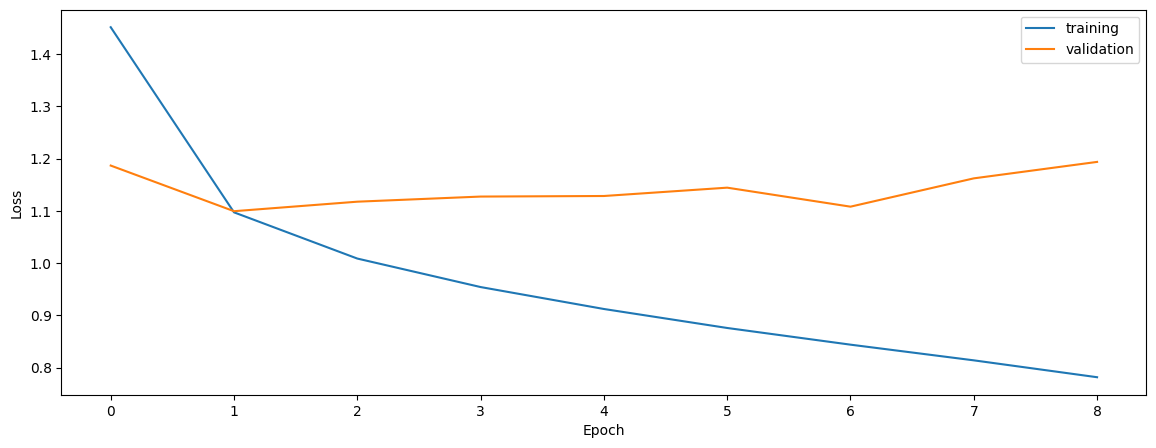

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['features'] = []
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

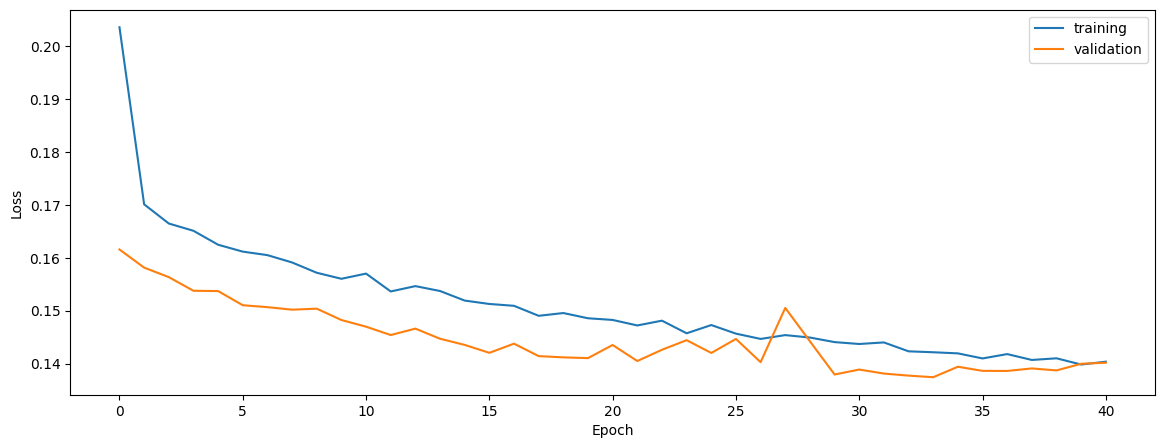

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.666280325500038
0.6660794965576592
0.6262270407050303


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6626056174259063
0.6599185829024095
0.6190070115595983


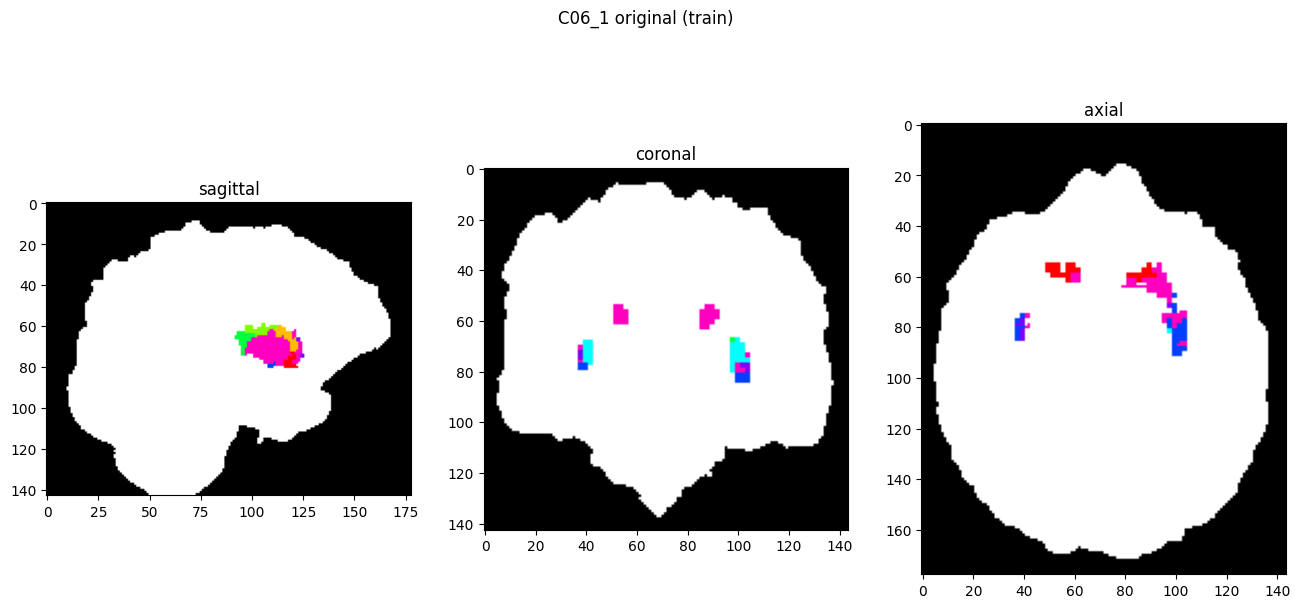

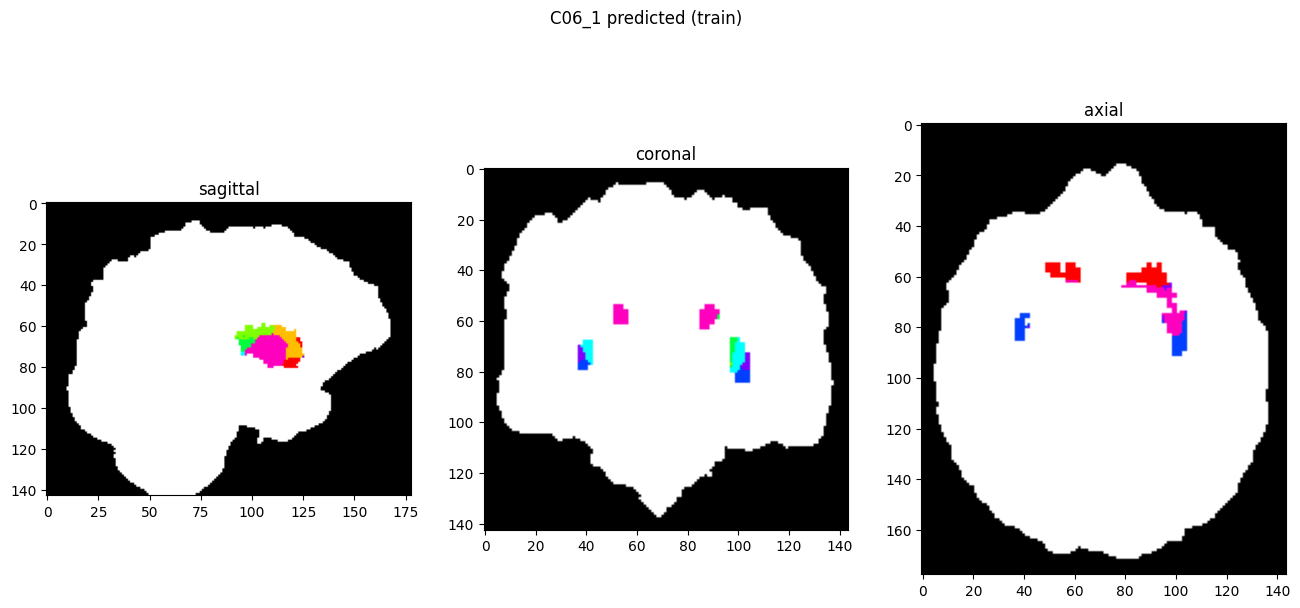

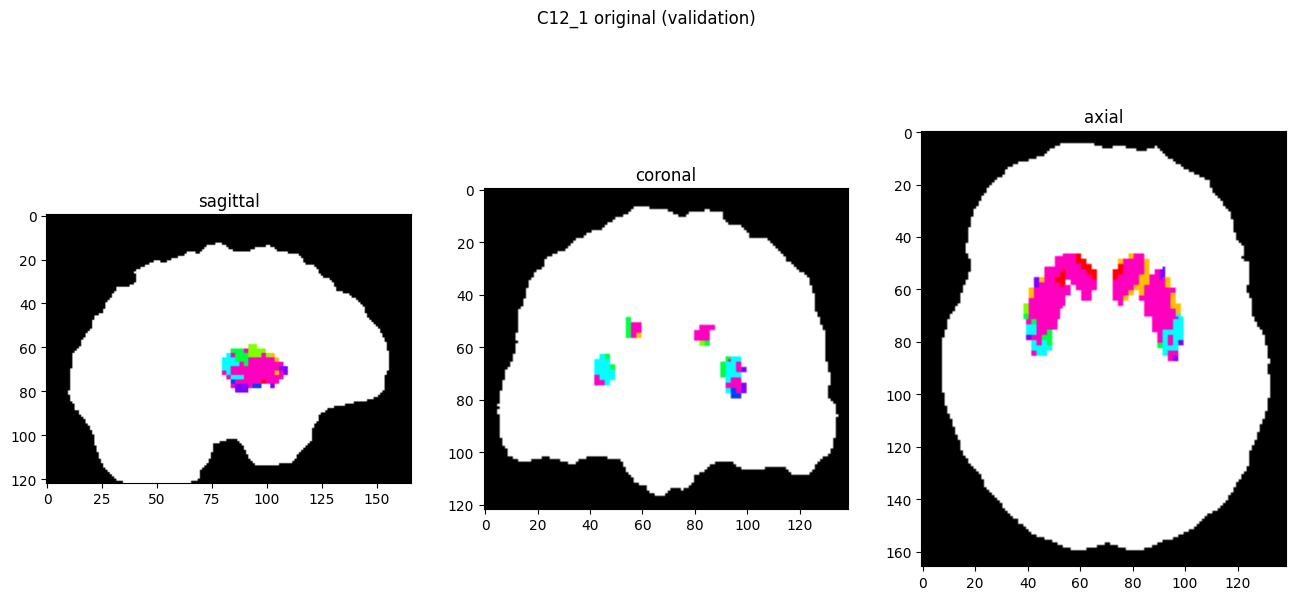

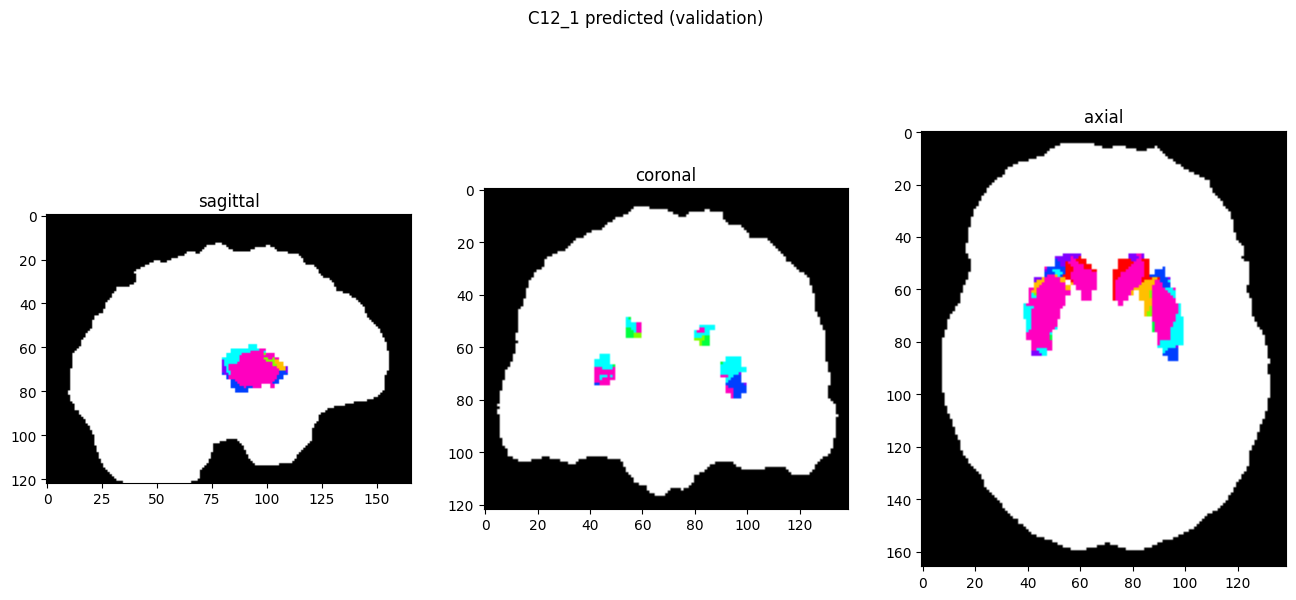

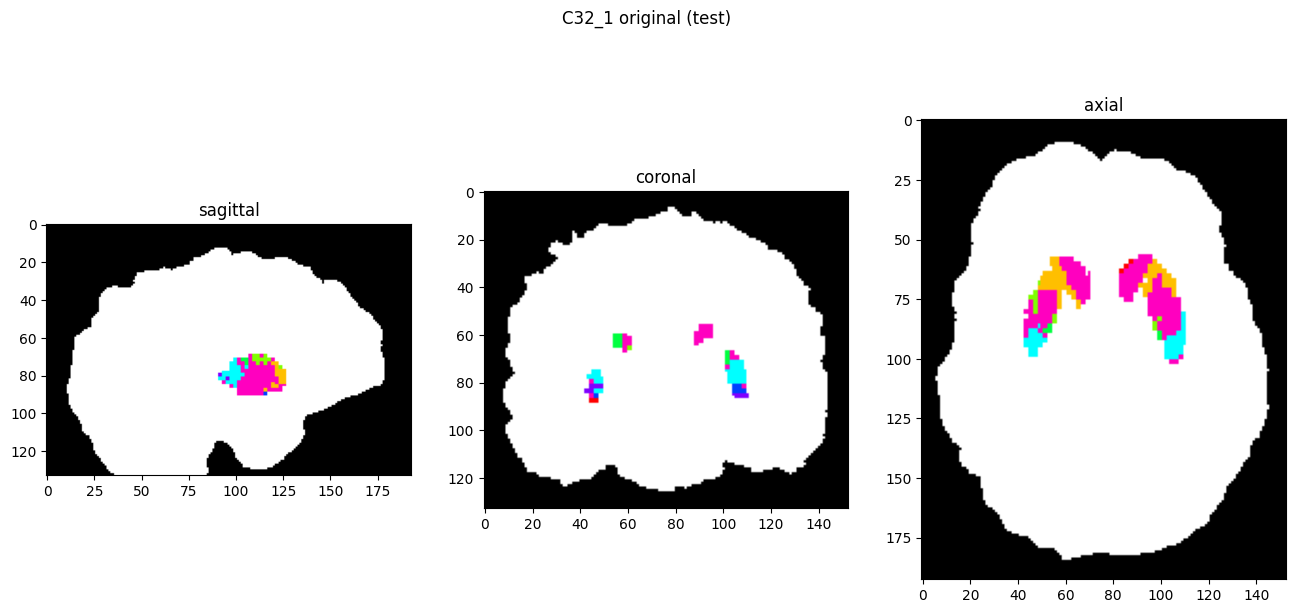

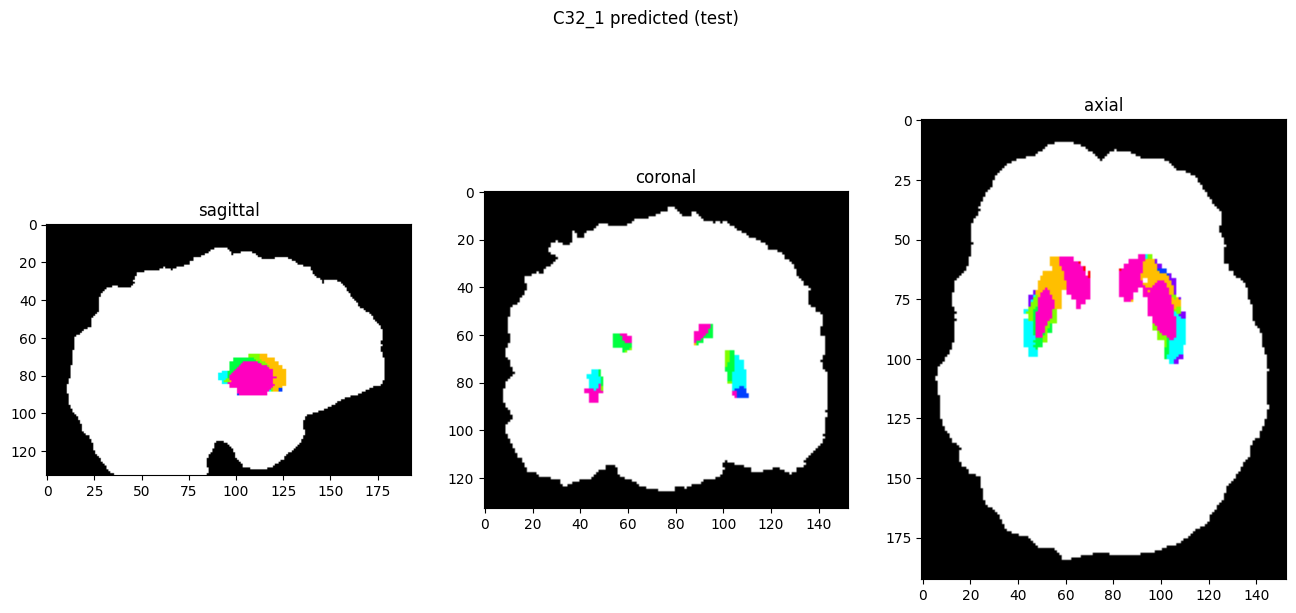

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)